## Importing functions

In [1]:
import os
import pandas as pd
import zipfile
import geopandas as gpd
from shapely.geometry import shape, Point
import matplotlib.pyplot as plt
import numpy as np
from rapidfuzz import fuzz, process
import folium
from scipy import stats
import fiona 


# Functions to load the data

In [2]:
data_folder = "data"

# 1. Load bus routes data from CSV file
def load_bus_routes_data():
    bus_routes_path = os.path.join(data_folder, "bus_routes_data.csv")
    if os.path.exists(bus_routes_path):
        bus_routes_df = pd.read_csv(bus_routes_path)
        return bus_routes_df
    else:
        print(f"Error: {bus_routes_path} not found.")
        return None

# 2. Load bus stops data from CSV file and convert to GeoDataFrame
def load_bus_stops_data():
    bus_stops_path = os.path.join(data_folder, "bus_stops_data.csv")
    if os.path.exists(bus_stops_path):
        bus_stops_df = pd.read_csv(bus_stops_path)
        # Create a GeoDataFrame for bus stops with Point geometries from Longitude and Latitude
        bus_stops_gdf = gpd.GeoDataFrame(
            bus_stops_df,
            geometry=gpd.points_from_xy(bus_stops_df['Longitude'], bus_stops_df['Latitude']),
            crs='EPSG:4326'
        )
        print("Bus Stops Data Loaded and converted to GeoDataFrame.")
        return bus_stops_gdf
    else:
        print(f"Error: {bus_stops_path} not found.")
        return None

# 3. Load Passenger Volume by Bus Stops data from ZIP file
def load_passenger_volume_bus_stops():
    zip_path = os.path.join(data_folder, "transport_node_bus_202408.zip")
    csv_file_name = "transport_node_bus_202408.csv"
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as z:
            with z.open(csv_file_name) as csv_file:
                passenger_volume_df = pd.read_csv(csv_file)
                print("Passenger Volume by Bus Stops Data Loaded.")
                return passenger_volume_df
    else:
        print(f"Error: {zip_path} not found.")
        return None

# 4. Load Origin-Destination Bus Stops data from ZIP file
def load_od_volume_bus_stops():
    zip_path = os.path.join(data_folder, "origin_destination_bus_202408.zip")
    csv_file_name = "origin_destination_bus_202408.csv"
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as z:
            with z.open(csv_file_name) as csv_file:
                od_volume_df = pd.read_csv(csv_file)
                print("Origin-Destination Bus Stops Data Loaded.")
                return od_volume_df
    else:
        print(f"Error: {zip_path} not found.")
        return None
    
# 5. Load MRT exits data from ZIP file
def load_mrt_exits_shapefile():
    zip_path = os.path.join('data', "train_station_exit_geospatial_whole_island_202408.zip")
    shapefile_components = [
        'TrainStationExit/Train_Station_Exit_Layer.shp',
        'TrainStationExit/Train_Station_Exit_Layer.dbf',
        'TrainStationExit/Train_Station_Exit_Layer.shx'
    ]

    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        
            temp_dir = 'temp_shapefile'  # Temporary folder for extraction
            os.makedirs(temp_dir, exist_ok=True)
            
            # Extract necessary shapefile components
            for component in shapefile_components:
                zip_ref.extract(component, path=temp_dir)

            # Load the shapefile into a GeoDataFrame
            shapefile_path = os.path.join(temp_dir, 'TrainStationExit', 'Train_Station_Exit_Layer.shp')
            gdf_exits = gpd.read_file(shapefile_path)

            # Clean up extracted files and temporary directory
            for component in shapefile_components:
                os.remove(os.path.join(temp_dir, component))
            
            # Remove the empty directory
            try:
                os.rmdir(os.path.join(temp_dir, 'TrainStationExit'))
                os.rmdir(temp_dir)
            except OSError as e:
                print(f"Warning: {e.strerror} - {e.filename}")
            
            print("MRT Exits data loaded.")
            
            # Display the columns (fields) and first few rows in the shapefile
            print("Columns in MRT Exits Shapefile:")
            print(gdf_exits.columns)
            print("\nFirst 5 rows of data:")
            print(gdf_exits.head())
            
            return gdf_exits
    else:
        print(f"Error: {zip_path} not found.")
        return None
    
# 6. Load mrtlines data
def load_mrt_lines_mapping():
    mrt_lines_path = os.path.join(data_folder, "singapore_mrt_stations_with_lines_filtered.csv")
    if os.path.exists(mrt_lines_path):
        mrt_lines_df = pd.read_csv(mrt_lines_path)
        return mrt_lines_df
    else:
        print(f"Error: {mrt_lines_path} not found.")

# 7. Load LTA Datamall Geospatial data 
def load_mrt_shapefile():
    zip_path = os.path.join('data', "train_station_geospatial_whole_island_202408.zip")
    shapefile_components = [
        'TrainStation_Jul2024/RapidTransitSystemStation.shp',
        'TrainStation_Jul2024/RapidTransitSystemStation.shx',
        'TrainStation_Jul2024/RapidTransitSystemStation.dbf',
        'TrainStation_Jul2024/RapidTransitSystemStation.prj'
    ]

    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        
            temp_dir = 'temp_shapefile'  # Temporary folder for extraction
            os.makedirs(temp_dir, exist_ok=True)
            
            # Extract necessary shapefile components
            for component in shapefile_components:
                zip_ref.extract(component, path=temp_dir)

            shapefile_path = os.path.join(temp_dir, 'TrainStation_Jul2024', 'RapidTransitSystemStation.shp')
            features = []    
            with fiona.open(shapefile_path, 'r') as src:
                for feature in src:
                    try:
                        geom = shape(feature['geometry'])  # Create a valid geometry
                        properties = feature['properties']
                        properties['geometry'] = geom
                        features.append(properties)
                    except Exception as e:
                        print(f"Skipped feature due to error: {e}")
            # Load the shapefile into a GeoDataFrame
            gdf_mrt = gpd.GeoDataFrame(features)

            # Clean up extracted files and temporary directory
            for component in shapefile_components:
                os.remove(os.path.join(temp_dir, component))
            
            # Remove the empty directory
            try:
                os.rmdir(os.path.join(temp_dir, 'TrainStationExit'))
                os.rmdir(temp_dir)
            except OSError as e:
                print(f"Warning: {e.strerror} - {e.filename}")
            
            print("MRT Exits data loaded.")
            
            # Display the columns (fields) and first few rows in the shapefile
            print("Columns in MRT Exits Shapefile:")
            print(gdf_mrt.columns)
            print("\nFirst 5 rows of data:")
            print(gdf_mrt.head())
            
            return gdf_mrt
    else:
        print(f"Error: {zip_path} not found.")
        return None

## Loading the Data

In [3]:
# Load datasets
bus_routes_df = load_bus_routes_data()
bus_stops_gdf = load_bus_stops_data()
passenger_volume_df = load_passenger_volume_bus_stops()
od_volume_df = load_od_volume_bus_stops()
mrt_exits_gdf = load_mrt_exits_shapefile()
mrt_lines_mapping = load_mrt_lines_mapping()
mrt_gdf = load_mrt_shapefile()


# Ensure that the data is being loaded correctly
if bus_routes_df is not None:
    print(f"Bus Routes DataFrame shape: {bus_routes_df.shape}")
if bus_stops_gdf is not None:
    print(f"Bus Stops GeoDataFrame shape: {bus_stops_gdf.shape}")
if passenger_volume_df is not None:
    print(f"Passenger Volume DataFrame shape: {passenger_volume_df.shape}")
if od_volume_df is not None:
    print(f"Origin-Destination Bus Stops DataFrame shape: {od_volume_df.shape}")
if mrt_exits_gdf is not None:
    print(f"MRT Exits GeoDataFrame shape: {mrt_exits_gdf.shape}")
if mrt_lines_mapping is not None:
    print(f"MRT Lines Mapping DataFrame shape: {mrt_lines_mapping.shape}")
if mrt_gdf is not None:
    print(f"MRT GeoDataFrame shape: {mrt_gdf.shape}")
    
mrt_gdf

Bus Stops Data Loaded and converted to GeoDataFrame.
Passenger Volume by Bus Stops Data Loaded.
Origin-Destination Bus Stops Data Loaded.
MRT Exits data loaded.
Columns in MRT Exits Shapefile:
Index(['stn_name', 'exit_code', 'geometry'], dtype='object')

First 5 rows of data:
                 stn_name exit_code                     geometry
0  MACPHERSON MRT STATION    Exit A  POINT (34285.068 34322.985)
1  MACPHERSON MRT STATION    Exit B  POINT (34382.153 34231.904)
2  MACPHERSON MRT STATION    Exit C  POINT (34337.292 34190.603)
3    TONGKANG LRT STATION    Exit B  POINT (33872.145 41256.053)
4    TONGKANG LRT STATION    Exit A  POINT (33858.542 41234.065)
MRT Exits data loaded.
Columns in MRT Exits Shapefile:
Index(['ATTACHEMEN', 'STN_NAM', 'STN_NAM_DE', 'TYP_CD', 'TYP_CD_DES',
       'geometry'],
      dtype='object')

First 5 rows of data:
  ATTACHEMEN STN_NAM                 STN_NAM_DE  TYP_CD TYP_CD_DES  \
0       None    None            GALI BATU DEPOT       0        MRT   
1  

C:\Users\brand\AppData\Local\Temp\ipykernel_29168\2229421588.py:141: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties['geometry'] = geom


ATTACHEMEN STN_NAM                      STN_NAM_DE  TYP_CD TYP_CD_DES  \
0         None    None                 GALI BATU DEPOT       0        MRT   
1         None    None            HILLVIEW MRT STATION       0        MRT   
2         None    None        BEAUTY WORLD MRT STATION       0        MRT   
3         None    None                HUME MRT STATION       0        MRT   
4         None    None       BUKIT PANJANG MRT STATION       0        MRT   
..         ...     ...                             ...     ...        ...   
225       None    None         KATONG PARK MRT STATION       0        MRT   
226       None    None      MARINE TERRACE MRT STATION       0        MRT   
227       None    None         TANJONG RHU MRT STATION       0        MRT   
228       None    None       MARINE PARADE MRT STATION       0        MRT   
229       None    None  FOUNDERS' MEMORIAL MRT STATION       0        MRT   

                                              geometry  
0    POLYGON ((19210.615 41858.041, 19223.517 41756...  
1    POLYGON ((20650.333 38282.331, 20654.77 38298....  
2    POLYGON ((21594.717 35882.935, 21584.857 35880...  
3    POLYGON ((20807.997 37457.716, 20815.376 37460...  
4    POLYGON ((19996.27 40187.205, 20028.77 40127.2...  
..                                                 ...  
225  POLYGON ((33758.889 31194.493, 33774.129 31193...  
226  POLYGON ((37233.989 32112.225, 37233.894 32112...  
227  POLYGON ((32437.392 30982.103, 32434.751 31045...  
228  POLYGON ((35926.26 31599.095, 35908.52 31625.1...  
229  POLYGON ((31918.469 30444.404, 31922.807 30446...  

[230 rows x 6 columns]

## Tagging bus stops to MRT Exit
We need to identify the bus stops that are linked to the MRT exits. There are 2 main ways to approach this:
1. String matching based on description
   1. We attempted this method and found that while it worked for most of the stations, it still caught on to alot of false positives. One false positive example is 'Carltex Stn', which is not a train station.
2. Distance matching based on MRT exits

## Tagging MRT Exits to MRT Stations
We will now determine which MRT station and MRT line does each exit belong to. We need to note that they may not always contain the exact match of the MRT station name. So we will use a fuzzy matching approach to find the closest match

Filter out the words MRT Station
If there is LRT, also filter out the whole thing

In [4]:
# Function to filter out "LRT", remove "MRT STATION", fuzzy match, and join MRT lines, then drop unwanted columns
def match_mrt_line_to_exits(mrt_lines_mapping, mrt_exits_gdf, threshold=50):
    # Step 1: Filter out rows containing "LRT" in the station name
    mrt_exits_gdf = mrt_exits_gdf[~mrt_exits_gdf['stn_name'].str.contains('LRT', case=False)]
    
    # Step 2: Remove "MRT STATION" from 'stn_name' before matching
    mrt_exits_gdf['stn_name_cleaned'] = mrt_exits_gdf['stn_name'].str.replace('MRT STATION', '', case=False).str.strip()

    # Step 3: Perform fuzzy matching and create a new column for the best matched station name
    # Get the MRT station names in lowercase for case-insensitive matching
    mrt_station_names = mrt_lines_mapping['Station name_English • Malay'].str.lower().tolist()
    
    matched_station_names = []  # List to store matched station names

    for idx, row in mrt_exits_gdf.iterrows():
        exit_description = row['stn_name_cleaned'].lower()  # Lowercase the cleaned station name for case-insensitive matching
        
        # Perform fuzzy matching to find the closest MRT station name
        match_result = process.extractOne(exit_description, mrt_station_names, scorer=fuzz.token_sort_ratio)
        
        if match_result:
            match, score, _ = match_result
            if score >= threshold:
                matched_station_names.append(match)
            else:
                matched_station_names.append(None)
        else:
            matched_station_names.append(None)
    
    # Add the matched station names to the GeoDataFrame as a new column
    mrt_exits_gdf['stn_name_matched'] = matched_station_names
    
    # Step 4: Perform a left join to the MRT lines mapping DataFrame
    # Standardize the MRT station names to lowercase for the merge
    mrt_lines_mapping['Station name_English • Malay'] = mrt_lines_mapping['Station name_English • Malay'].str.lower()

    # Left join based on the matched station names
    mrt_exits_gdf = mrt_exits_gdf.merge(mrt_lines_mapping, 
                                        left_on='stn_name_matched', 
                                        right_on='Station name_English • Malay', 
                                        how='left')

    # Step 5: Drop the unnecessary columns
    cols_to_drop = ['Matched_MRT_Line', 'stn_name_cleaned', 'MRT_Lines']
    mrt_exits_gdf.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    return mrt_exits_gdf

# Example of calling the function
mrt_exits_gdf_mapped = match_mrt_line_to_exits(mrt_lines_mapping, mrt_exits_gdf)

# Display the updated DataFrame
print(mrt_exits_gdf_mapped.head())


                 stn_name exit_code                     geometry  \
0  MACPHERSON MRT STATION    Exit A  POINT (34285.068 34322.985)   
1  MACPHERSON MRT STATION    Exit A  POINT (34285.068 34322.985)   
2  MACPHERSON MRT STATION    Exit B  POINT (34382.153 34231.904)   
3  MACPHERSON MRT STATION    Exit B  POINT (34382.153 34231.904)   
4  MACPHERSON MRT STATION    Exit C  POINT (34337.292 34190.603)   

  stn_name_matched Station name_English • Malay  NS  EW  DT  CC  NE  TE  CG  \
0       macpherson                   macpherson   0   0   1   1   0   0   0   
1       macpherson                   macpherson   0   0   1   1   0   0   0   
2       macpherson                   macpherson   0   0   1   1   0   0   0   
3       macpherson                   macpherson   0   0   1   1   0   0   0   
4       macpherson                   macpherson   0   0   1   1   0   0   0   

   CE  
0   0  
1   0  
2   0  
3   0  
4   0  


c:\Users\brand\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\brand\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


##### Why remove LRT?
The function of a LRT is very different from the MRT. The current LRT system focuses on serving a small and concentrated area, such as the residential estate, whereas the MRT serves the entire Singapore. Given the small area that it runs, we believe that by inclduing the LRT for our route examination as the probability of it running the same route as our bus services is very high.

This will result in false positives - We will incorrectly flag bus routes as 'redundant'

### Optimal Distance
In reality, we believe that bus stops less than 1 MRT distance away from MRT stations are considered MRT Bus Stops. 

So to find the optimal distance, we check the bus routes to find the average distance between two bus stops, excluding the outliers.

Number of global outlier stops: 224


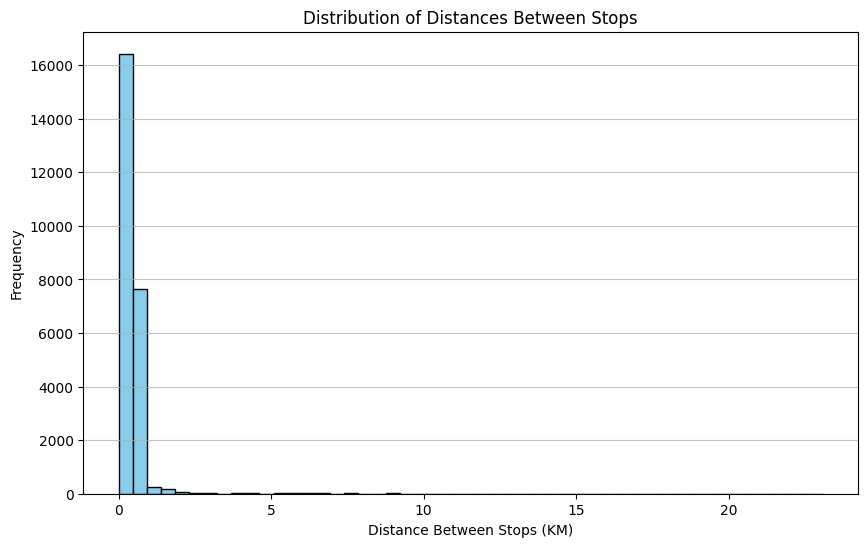

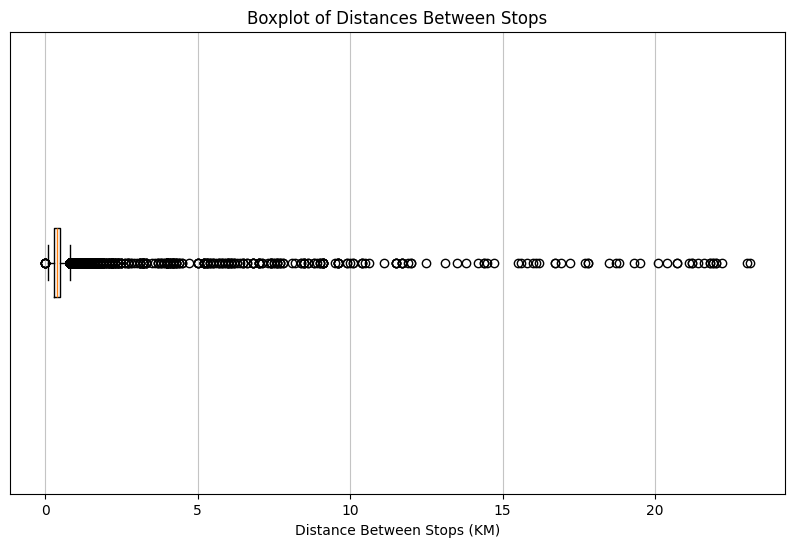

Average distance between stops: 0.51 km
Median distance between stops: 0.40 km
Average distance between stops after removing outliers: 0.43 km
Median distance between stops after removing outliers: 0.40 km


In [5]:
# Sort the data
bus_routes_df_sorted = bus_routes_df.sort_values(by=['ServiceNo', 'Direction', 'StopSequence'])

# Calculate the distance between stops
bus_routes_df_sorted['DistanceBetweenStops'] = bus_routes_df_sorted.groupby(['ServiceNo', 'Direction'])['Distance'].diff()

# Drop NaN values resulting from diff()
bus_routes_df_sorted = bus_routes_df_sorted.dropna(subset=['DistanceBetweenStops'])

# Calculate z-scores across all distances between stops
bus_routes_df_sorted['z_score_global'] = stats.zscore(bus_routes_df_sorted['DistanceBetweenStops'])

# Define a threshold for z-score to identify outliers
threshold = 3.5  # You can adjust this value

# Identify outliers
global_outliers = bus_routes_df_sorted[np.abs(bus_routes_df_sorted['z_score_global']) > threshold]

print("Number of global outlier stops:", global_outliers.shape[0])

# Plot out the distribution of distances between stops
plt.figure(figsize=(10, 6))
plt.hist(bus_routes_df_sorted['DistanceBetweenStops'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Distances Between Stops')
plt.xlabel('Distance Between Stops (KM)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Plot the boxplot of distances between stops
plt.figure(figsize=(10, 6))
plt.boxplot(bus_routes_df_sorted['DistanceBetweenStops'], vert=False)
plt.title('Boxplot of Distances Between Stops')
plt.xlabel('Distance Between Stops (KM)')
plt.yticks([])
plt.grid(axis='x', alpha=0.75)
plt.show()

# Average and median distance between stops
average_distance = bus_routes_df_sorted['DistanceBetweenStops'].mean()
median_distance = bus_routes_df_sorted['DistanceBetweenStops'].median()
print(f"Average distance between stops: {average_distance:.2f} km")
print(f"Median distance between stops: {median_distance:.2f} km")

# Distance after removing outliers
filtered_distance = bus_routes_df_sorted[np.abs(bus_routes_df_sorted['z_score_global']) <= threshold]['DistanceBetweenStops']
filtered_average_distance = filtered_distance.mean()
filtered_median_distance = filtered_distance.median()
print(f"Average distance between stops after removing outliers: {filtered_average_distance:.2f} km")
print(f"Median distance between stops after removing outliers: {filtered_median_distance:.2f} km")


So from above, even after removing the outliers, the median distance between stops is still ~400m. So now, we will be using 400m as the optimal distance

Using the optimal distance found, we can assume that bus stops within 1 MRT station can be tagged as a MRT bus stop. So presumably, if the bus stop is ~500m away from the MRT, technically we can assume that it is sufficiently close to walk to a MRT station.

In [6]:
optimal_distance = filtered_median_distance * 1000  # Convert to meters
print(f"Optimal distance between stops: {optimal_distance:.2f} m")
# Function to tag bus stops with MRT proximity and include MRT line indicators
def tagging_mrt_to_bus_stops(y, x, distance=optimal_distance):
    # Set CRS if not already defined
    if y.crs is None:
        y = y.set_crs(epsg=3414)  # Use SVY21 (Singapore)
    if x.crs is None:
        x = x.set_crs(epsg=3414)  # WGS84 for bus stops

    # Re-project MRT exits to EPSG:4326 (WGS84) to match bus stops
    y = y.to_crs(epsg=3414)

    projected_crs = "EPSG:3857"  # Mercator projection in meters
    y_projected = y.to_crs(projected_crs)
    x_projected = x.to_crs(projected_crs)

    # Perform a spatial join to find the nearest bus stop for each MRT exit
    nearest_bus_stops = gpd.sjoin_nearest(
        y_projected, 
        x_projected, 
        how="left", 
        distance_col="distance"  # Create a column for the distance between the points
    )
    
    # Filter based on the specified distance to ensure we're tagging bus stops correctly
    nearest_bus_stops_filtered = nearest_bus_stops[nearest_bus_stops['distance'] <= distance]

    # Tag bus stops that are within the specified distance as MRT-related
    x['is_mrt'] = x_projected.index.isin(nearest_bus_stops_filtered['index_right'])

    # Perform a normal left merge to bring in MRT line information and matched MRT station
    # We use `BusStopCode` and `index_right` to perform the merge
    merged = x.merge(nearest_bus_stops_filtered[['stn_name_matched', 'NS', 'EW', 'DT', 'CC', 'NE', 'TE', 'CG', 'CE', 'index_right', 'distance']],
                     left_index=True, right_on='index_right', 
                     how='left')

    merged = merged.rename(columns={
        'geometry_x': 'geometry_bus',
        'geometry_y': 'geometry_mrt'
    })
    
    # Filter out duplicate BusStopCode entries
    merged = merged.drop_duplicates(subset='BusStopCode')

    return merged

# Call the function with the MRT exits and bus stops GeoDataFrames
tagging = tagging_mrt_to_bus_stops(mrt_exits_gdf_mapped, bus_stops_gdf)

# Filter only the MRT-related bus stops
bus_stops_mrt = tagging[tagging['is_mrt'] == True]

print(bus_stops_mrt.head())
bus_stops_mrt


Optimal distance between stops: 400.00 m
       BusStopCode     RoadName              Description  Latitude  \
277.0         1059  Victoria St         Bugis Stn Exit B  1.300757   
271.0         1112  Victoria St     Opp Bugis Stn Exit C  1.300092   
279.0         1113  Victoria St         Bugis Stn Exit A  1.301173   
344.0         1319   Kallang Rd  Lavender Stn Exit A/ICA  1.307574   
472.0         1541    Rochor Rd         Bugis Stn Exit D  1.298865   

        Longitude                   geometry  is_mrt stn_name_matched   NS  \
277.0  103.856110  POINT (103.85611 1.30076)    True            bugis  0.0   
271.0  103.855200   POINT (103.8552 1.30009)    True            bugis  0.0   
279.0  103.856114  POINT (103.85611 1.30117)    True            bugis  0.0   
344.0  103.863256  POINT (103.86326 1.30757)    True         lavender  0.0   
472.0  103.857346  POINT (103.85735 1.29886)    True            bugis  0.0   

        EW   DT   CC   NE   TE   CG   CE  index_right   distance  
27

BusStopCode            RoadName              Description  Latitude  \
277.0         1059         Victoria St         Bugis Stn Exit B  1.300757   
271.0         1112         Victoria St     Opp Bugis Stn Exit C  1.300092   
279.0         1113         Victoria St         Bugis Stn Exit A  1.301173   
344.0         1319          Kallang Rd  Lavender Stn Exit A/ICA  1.307574   
472.0         1541           Rochor Rd         Bugis Stn Exit D  1.298865   
...            ...                 ...                      ...       ...   
410.0        95129       PTB2 Basement     Changi Airport Ter 2  1.355093   
431.0        96041  Upp Changi Rd East  Upp Changi Stn/Opp SUTD  1.341552   
390.0        96049  Upp Changi Rd East      Upp Changi Stn/SUTD  1.340874   
470.0        96169          Simei St 3                Simei Stn  1.342262   
124.0        96301    Changi Sth Ave 1          EXPO STN EXIT B  1.334500   

        Longitude                   geometry  is_mrt stn_name_matched   NS  \
277.0  103.856110  POINT (103.85611 1.30076)    True            bugis  0.0   
271.0  103.855200   POINT (103.8552 1.30009)    True            bugis  0.0   
279.0  103.856114  POINT (103.85611 1.30117)    True            bugis  0.0   
344.0  103.863256  POINT (103.86326 1.30757)    True         lavender  0.0   
472.0  103.857346  POINT (103.85735 1.29886)    True            bugis  0.0   
...           ...                        ...     ...              ...  ...   
410.0  103.989220  POINT (103.98922 1.35509)    True   changi airport  0.0   
431.0  103.961237  POINT (103.96124 1.34155)    True     upper changi  0.0   
390.0  103.961433  POINT (103.96143 1.34087)    True     upper changi  0.0   
470.0  103.953466  POINT (103.95347 1.34226)    True            simei  0.0   
124.0  103.961744   POINT (103.96174 1.3345)    True             expo  0.0   

        EW   DT   CC   NE   TE   CG   CE  index_right    distance  
277.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0            5   25.341418  
271.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0            7   54.864321  
279.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0            8   21.424779  
344.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0           19   50.925420  
472.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0           32   56.002992  
...    ...  ...  ...  ...  ...  ...  ...          ...         ...  
410.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0         4936  139.159048  
431.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0         4959   35.933334  
390.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0         4960   43.562840  
470.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0         4984   59.329046  
124.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0         5009   94.121336  

[284 rows x 18 columns]

### Checking MRT stops
Just for future debugging, ensuring that our works are correct. We can consider using this for our frontend too

In [7]:
sg_map = folium.Map(location=[1.38, 103.8], zoom_start=12)

# Loop through the DataFrame to create markers
for idx, row in bus_stops_mrt.iterrows():
    # Construct the popup message dynamically
    popup_content = f"MRT Station: {row['stn_name_matched']}<br>Train Lines: "
    
    # List the train lines that are associated with the MRT station
    lines = []
    if row['NS'] > 0: lines.append('NS Line')
    if row['EW'] > 0: lines.append('EW Line')
    if row['DT'] > 0: lines.append('DT Line')
    if row['CC'] > 0: lines.append('CC Line')
    if row['NE'] > 0: lines.append('NE Line')
    if row['TE'] > 0: lines.append('TE Line')
    if row['CG'] > 0: lines.append('CG Line')
    if row['CE'] > 0: lines.append('CE Line')

    popup_content += ', '.join(lines) if lines else 'No lines available'

    # Create a marker for each bus stop with the associated MRT information
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=folium.Popup(popup_content, max_width=300),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(sg_map)

# Display the map
sg_map


In [8]:
import pandas as pd

## merge bus routes data with bus stops data
bus_df_w_routes_and_coordinates = pd.merge(bus_routes_df, bus_stops_gdf, on='BusStopCode', how='left')
#bus_df_w_routes_and_coordinates.to_csv('bus_routes_with_coordinates.csv', index=False)
#print("File Successfully saved")


In [124]:
## checking correct df
##bus_df_w_routes_and_coordinates.head(6)

<h1>Plotting all bus routes available in Singapore using the OSRM API</h1>

We first grouped the bus routes by 'ServiceNo' and 'Direction'. To ensure that the route follows the correct order of bus stops, we then sorted the data by 'StopSequence'.
For each consecutive pair of bus stops, we made an OSRM query to fetch the encoded polyline between them. The encoded polyline shows the route between the two stops via road network. 
The encoded polylines are then stored into a Dataframe and saved to a csv file for further analysis.
To represent the bus routes, we then decoded the encoded polylines and displayed them on a Folium map.

Note: Run the first code chunk to test with one route first. 

In [ ]:
import folium
import pandas as pd
import requests
import polyline  


def get_osrm_encoded_route(start_coords, end_coords):
    osrm_url = f"http://router.project-osrm.org/route/v1/driving/{start_coords[1]},{start_coords[0]};{end_coords[1]},{end_coords[0]}?geometries=polyline"
    response = requests.get(osrm_url)
    if response.status_code == 200:
        data = response.json()
        if 'routes' in data and len(data['routes']) > 0:
            return data['routes'][0]['geometry']  ## returns encoded polyline
    return None

## creating sg map
mymap_test = folium.Map(location=[1.3521, 103.8198], zoom_start=12)
unique_services = bus_df_w_routes_and_coordinates['ServiceNo'].unique()[:1]

## filter for unique buses
filtered_bus_df = bus_df_w_routes_and_coordinates[bus_df_w_routes_and_coordinates['ServiceNo'].isin(unique_services)]
bus_routes_grouped = filtered_bus_df.groupby(['ServiceNo', 'Direction'])


output_data = []
line_color = 'blue'  


for (service_no, direction), group in bus_routes_grouped:
    
    group = group.sort_values(by='StopSequence') ## sort group by stopsequence 
    bus_stops = list(zip(group['Latitude'], group['Longitude']))
    
    ## get subsequent roads for next busstops
    for i in range(len(bus_stops) - 1):
        start_coords = bus_stops[i]
        end_coords = bus_stops[i + 1]
        
        
        encoded_route = get_osrm_encoded_route(start_coords, end_coords) ##encoded route between busstops
        if encoded_route:
            output_data.append({
                "ServiceNo": service_no,
                "Direction": direction,
                "EncodedPolyline": encoded_route
            })
            
            decoded_route = polyline.decode(encoded_route) ## decode encoded polyline to lat long
            
            ## map decoded route on the sg map
            folium.PolyLine(decoded_route, color=line_color, weight=2.5, opacity=1,
                            popup=f"Bus {service_no} Direction {direction}").add_to(mymap_test)

## convert output data to df
df_encoded_polylines = pd.DataFrame(output_data)
## save to csv
df_encoded_polylines.to_csv('encoded_polylines_output_test.csv', index=False)
mymap_test


In [ ]:
import folium
import pandas as pd
import requests
import polyline  


def get_osrm_encoded_route(start_coords, end_coords):
    osrm_url = f"http://router.project-osrm.org/route/v1/driving/{start_coords[1]},{start_coords[0]};{end_coords[1]},{end_coords[0]}?geometries=polyline"
    response = requests.get(osrm_url)
    if response.status_code == 200:
        data = response.json()
        if 'routes' in data and len(data['routes']) > 0:
            return data['routes'][0]['geometry']  ## returns encoded polyline
    return None

## creating sg map
map_of_all_bus_routes = folium.Map(location=[1.3521, 103.8198], zoom_start=12)
unique_services = bus_df_w_routes_and_coordinates['ServiceNo'].unique()[:600]

## filter for unique buses
filtered_bus_df = bus_df_w_routes_and_coordinates[bus_df_w_routes_and_coordinates['ServiceNo'].isin(unique_services)]
bus_routes_grouped = filtered_bus_df.groupby(['ServiceNo', 'Direction'])


output_data = []
line_color = 'blue'  


for (service_no, direction), group in bus_routes_grouped:
    
    group = group.sort_values(by='StopSequence') ## sort group by stopsequence 
    bus_stops = list(zip(group['Latitude'], group['Longitude']))
    
    ## get subsequent roads for next busstops
    for i in range(len(bus_stops) - 1):
        start_coords = bus_stops[i]
        end_coords = bus_stops[i + 1]
        
        
        encoded_route = get_osrm_encoded_route(start_coords, end_coords) ##encoded route between busstops
        if encoded_route:
            output_data.append({
                "ServiceNo": service_no,
                "Direction": direction,
                "EncodedPolyline": encoded_route
            })
            
            decoded_route = polyline.decode(encoded_route) ## decode encoded polyline to lat long
            
            ## map decoded route on the sg map
            folium.PolyLine(decoded_route, color=line_color, weight=2.5, opacity=1,
                            popup=f"Bus {service_no} Direction {direction}").add_to(map_of_all_bus_routes)

## convert output data to df
df_encoded_polylines = pd.DataFrame(output_data)
## save to csv
df_encoded_polylines.to_csv('encoded_polylines_output.csv', index=False)
map_of_all_bus_routes


# Aggregating all the geometries from one bus stop to another bus stop into a Singular Geometry object by Bus Service Number 

In [10]:
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge
import polyline  

# Step 1: Function to decode polyline and convert to LineString
def decode_polyline_to_geometry(encoded_polyline):
    # Decode polyline into a list of (lat, lon) tuples
    coords = polyline.decode(encoded_polyline)
    # Convert to LineString object (lon, lat for shapely)
    return LineString([(lon, lat) for lat, lon in coords])

# Step 2: Apply the decoding function to the 'EncodedPolyLine' column
df_encoded_polylines['geometry'] = df_encoded_polylines['EncodedPolyline'].apply(decode_polyline_to_geometry)

print(f"this is df_encoded_polylines:\n {df_encoded_polylines.head(5)}")

# Step 3: Group the dataframe by ServiceNo and collect all LineStrings into a list
df_bus_grouped_geometry = df_encoded_polylines.groupby('ServiceNo')['geometry'].apply(list)
# Use linemerge to create a single LineString from all the geometries
df_bus_grouped_geometry = df_bus_grouped_geometry.apply(lambda x: linemerge(MultiLineString(x)))

print(f"this is df_bus_grouped_geometry:\n {df_bus_grouped_geometry.head(5)}")

# Step 3: Convert the grouped data back into a DataFrame for further analysis
df_bus_combined_geometry = df_bus_grouped_geometry.reset_index()
df_bus_combined_geometry.columns = ['ServiceNo', 'geometry']

# Step 4: Display the result
print(f"this is df_bus_combined_geometry:\n {df_bus_combined_geometry.head(5)}")

# Step 4: Initialize a Folium map (centered at Singapore coordinates for example)
m = folium.Map(location=[1.3521, 103.8198], zoom_start=12)

# Step 5: Plot each merged bus route on the Folium map
for _, row in df_bus_combined_geometry.iterrows():
    geom = row['geometry']
    
    # Handle the merged geometry after linemerge (could be LineString or MultiLineString)
    if geom.geom_type == 'LineString':
        coords = [(lat, lon) for lon, lat in geom.coords]
        folium.PolyLine(coords, color='blue', weight=2.5, opacity=0.8).add_to(m)
    elif geom.geom_type == 'MultiLineString':
        for line in geom.geoms:
            coords = [(lat, lon) for lon, lat in line.coords]
            folium.PolyLine(coords, color='blue', weight=2.5, opacity=0.8).add_to(m)

# Step 6: Display or save the map
m

this is df_encoded_polylines:
   ServiceNo  Direction             EncodedPolyline  \
0        10          1  ekgGemlyRfAhAeB~Au@L?vDxE@   
1        10          1         _ggGsalyRhJAvCKjImA   
2        10          1     qlfGodlyRrEu@xCeAbj@sb@   
3        10          1           _vdG_lmyRdGqEtGsF   
4        10          1           cedGezmyR`McKnE~M   

                                            geometry  
0  LINESTRING (103.94339 1.35363, 103.94302 1.353...  
1  LINESTRING (103.94154 1.35296, 103.94155 1.351...  
2  LINESTRING (103.942 1.34873, 103.94227 1.34767...  
3  LINESTRING (103.94832 1.34, 103.94937 1.33869,...  
4  LINESTRING (103.95059 1.3373, 103.95253 1.3350...  
this is df_bus_grouped_geometry:
 ServiceNo
10      LINESTRING (103.76868 1.29202, 103.76821 1.292...
100     LINESTRING (103.78715 1.31167, 103.78688 1.311...
100A    LINESTRING (103.87136 1.35037, 103.87167 1.348...
101     LINESTRING (103.87136 1.35037, 103.87163 1.348...
102     LINESTRING (103.86909 1.39288,

In [11]:
# Converting to a GPD
df_bus_combined_geometry = gpd.GeoDataFrame(
    df_bus_combined_geometry, geometry='geometry'
)
df_bus_combined_geometry

ServiceNo                                           geometry
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...
..        ...                                                ...
551      991C  LINESTRING (103.7363 1.37665, 103.73601 1.3764...
552       992  LINESTRING (103.72925 1.3575, 103.73042 1.3562...
553       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...
554        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...
555        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...

[556 rows x 2 columns]

In [12]:
# Setting the CRS 
print(df_bus_combined_geometry.crs)
if df_bus_combined_geometry.crs is None:
    # Assuming the original CRS is EPSG:3414 (SVY21, common in Singapore)
    df_bus_combined_geometry = df_bus_combined_geometry.set_crs(epsg=4326) 
print(df_bus_combined_geometry.crs)
df_bus_combined_geometry

None
EPSG:4326


ServiceNo                                           geometry
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...
..        ...                                                ...
551      991C  LINESTRING (103.7363 1.37665, 103.73601 1.3764...
552       992  LINESTRING (103.72925 1.3575, 103.73042 1.3562...
553       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...
554        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...
555        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...

[556 rows x 2 columns]

# Processing LTA Datamall MRT Geospatial Data 
Goal: To have a geometry object representing every MRT Line in Singapore and concat to `df_bus_combined_geometry` (that contains the geometry object of each bus service number)
This is so that we are able to calculate the parallelism of bus routes with mrt lines 

Steps:
1) Setting the Coordinate Reference System for the LTA Datamall MRT Geospatial Data
2) Categorise MRT Stations into its respective lines and order them in right sequence (so that we can connect MRT Stations)
3) Every station in LTA Datamall's MRT Geospatial Data is represented by Polygon(s)
4) For each MRT_Line, connect the centroid of each station's Polygon(s) to form a "Line"
4) Within each MRT_Line, union the "Line" and all the Polygon(s) of all stations to form a singular geometry object representing the MRT_Line 

In [13]:
# Convert GeoDataFrame's geometry to latitude and longitude coordinates
if mrt_gdf.crs is None:
    # Assuming the original CRS is EPSG:3414 (SVY21, common in Singapore)
    mrt_gdf = mrt_gdf.set_crs(epsg=3414) 
mrt_gdf = mrt_gdf.set_geometry('geometry').to_crs(epsg=4326)
mrt_gdf['centroid'] = mrt_gdf['geometry'].centroid
mrt_gdf['lat'] = mrt_gdf['centroid'].y
mrt_gdf['lon'] = mrt_gdf['centroid'].x


# Create a folium map centered around the mean coordinates of the MRT stations
mrt_map = folium.Map(
    location=[1.3521, 103.8198],
    zoom_start=12
)

# Add markers for each MRT station
for _, row in mrt_gdf.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"<b>{row['STN_NAM_DE']}</b>",  # Adjust this field as needed
        tooltip=row['STN_NAM_DE']
    ).add_to(mrt_map)

# Display the map
mrt_map

C:\Users\brand\AppData\Local\Temp\ipykernel_29168\3244018866.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mrt_gdf['centroid'] = mrt_gdf['geometry'].centroid


In [14]:
mrt_gdf

ATTACHEMEN STN_NAM                      STN_NAM_DE  TYP_CD TYP_CD_DES  \
0         None    None                 GALI BATU DEPOT       0        MRT   
1         None    None            HILLVIEW MRT STATION       0        MRT   
2         None    None        BEAUTY WORLD MRT STATION       0        MRT   
3         None    None                HUME MRT STATION       0        MRT   
4         None    None       BUKIT PANJANG MRT STATION       0        MRT   
..         ...     ...                             ...     ...        ...   
225       None    None         KATONG PARK MRT STATION       0        MRT   
226       None    None      MARINE TERRACE MRT STATION       0        MRT   
227       None    None         TANJONG RHU MRT STATION       0        MRT   
228       None    None       MARINE PARADE MRT STATION       0        MRT   
229       None    None  FOUNDERS' MEMORIAL MRT STATION       0        MRT   

                                              geometry  \
0    POLYGON ((103.75434 1.39482, 103.75445 1.39391...   
1    POLYGON ((103.76728 1.36249, 103.76732 1.36263...   
2    POLYGON ((103.77576 1.34079, 103.77567 1.34077...   
3    POLYGON ((103.76869 1.35503, 103.76876 1.35505...   
4    POLYGON ((103.7614 1.37971, 103.76169 1.37917,...   
..                                                 ...   
225  POLYGON ((103.88506 1.29839, 103.8852 1.29838,...   
226  POLYGON ((103.91629 1.30668, 103.91629 1.30669...   
227  POLYGON ((103.87319 1.29647, 103.87317 1.29704...   
228  POLYGON ((103.90454 1.30204, 103.90438 1.30228...   
229  POLYGON ((103.86853 1.2916, 103.86857 1.29162,...   

                      centroid       lat         lon  
0    POINT (103.75609 1.39759)  1.397585  103.756092  
1    POINT (103.76743 1.36234)  1.362340  103.767429  
2     POINT (103.77582 1.3412)  1.341204  103.775819  
3     POINT (103.7691 1.35451)  1.354511  103.769104  
4    POINT (103.76157 1.37916)  1.379160  103.761573  
..                         ...       ...         ...  
225  POINT (103.88618 1.29782)  1.297822  103.886182  
226  POINT (103.91532 1.30679)  1.306786  103.915316  
227  POINT (103.87345 1.29721)  1.297215  103.873452  
228  POINT (103.90551 1.30287)  1.302865  103.905508  
229  POINT (103.86892 1.29098)  1.290979  103.868916  

[230 rows x 9 columns]

In [15]:
mrt_lines_mapping

Station name_English • Malay MRT_Lines  NS  EW  DT  CC  NE  TE  CG  CE
0         north–south line (nsl)        NS   1   0   0   0   0   0   0   0
1                    jurong east        NS   1   1   0   0   0   0   0   0
2                    bukit batok        NS   1   0   0   0   0   0   0   0
3                   bukit gombak        NS   1   0   0   0   0   0   0   0
4                  choa chu kang        NS   1   0   0   0   0   0   0   0
..                           ...       ...  ..  ..  ..  ..  ..  ..  ..  ..
182                  bright hill        TE   0   0   0   0   0   1   0   0
183             king albert park        DT   0   0   1   0   0   0   0   0
184                     clementi        EW   0   1   0   0   0   0   0   0
185                      riviera        PE   0   0   0   0   0   0   0   0
186                      punggol        NE   0   0   0   0   1   0   0   0

[187 rows x 10 columns]

In [16]:
def get_ordered_mrt_lines_mapping(mrt_lines_mapping):
    # Drop redundant rows
    filtered_mrt_lines = mrt_lines_mapping[(mrt_lines_mapping['Station name_English • Malay'] != "north–south line (nsl)") & (mrt_lines_mapping['Station name_English • Malay'] != "downtown line (dtl)")].copy()
    # Group by each MRT Line, order them by the correct sequence
    filtered_mrt_lines['order'] = filtered_mrt_lines.groupby('MRT_Lines').cumcount() + 1
    # Remove duplicate MRT stations in each MRT Line
    filtered_mrt_lines = filtered_mrt_lines.sort_values('order').drop_duplicates(subset=['MRT_Lines', 'Station name_English • Malay'], keep='first')
    return filtered_mrt_lines

ordered_mrt_lines_mapping = get_ordered_mrt_lines_mapping(mrt_lines_mapping)
ordered_mrt_lines_mapping

Station name_English • Malay MRT_Lines  NS  EW  DT  CC  NE  TE  CG  CE  \
1                    jurong east        NS   1   1   0   0   0   0   0   0   
28                     pasir ris        EW   0   1   0   0   0   0   0   0   
61                          expo        CG   0   0   1   0   0   0   1   0   
63                  harbourfront        NE   0   0   0   1   1   0   0   0   
111                bukit panjang        DT   0   0   1   0   0   0   0   0   
..                           ...       ...  ..  ..  ..  ..  ..  ..  ..  ..   
59                tuas west road        EW   0   1   0   0   0   0   0   0   
142                tampines east        DT   0   0   1   0   0   0   0   0   
60                     tuas link        EW   0   1   0   0   0   0   0   0   
143                 upper changi        DT   0   0   1   0   0   0   0   0   
144                         expo        DT   0   0   1   0   0   0   1   0   

     order  
1        1  
28       1  
61       1  
63       1  
111      1  
..     ...  
59      32  
142     32  
60      33  
143     33  
144     34  

[171 rows x 11 columns]

In [17]:
# Function to filter out "LRT", remove "MRT STATION", fuzzy match, and join MRT lines, then drop unwanted columns
def match_mrt_lines(ordered_mrt_lines_mapping, mrt_gdf, threshold=50):
    # Step 1: Filter out LRTs and 'DEPOT' stations
    filtered_mrt_gdf = mrt_gdf[(mrt_gdf['TYP_CD_DES'] == "MRT") & (~mrt_gdf['STN_NAM_DE'].str.contains('DEPOT', case=False))].copy()

    # Step 2: Remove "MRT STATION" from 'STN_NAM_DE' before matching and convert to lower case
    filtered_mrt_gdf['stn_name_cleaned'] = filtered_mrt_gdf['STN_NAM_DE'].str.replace('MRT STATION', '', case=False).str.strip()

    # Step 3: Perform fuzzy matching and create a new column for the best matched station name
    # Get the MRT station names in lowercase for case-insensitive matching
    mrt_station_names = ordered_mrt_lines_mapping['Station name_English • Malay'].str.lower().tolist()
    
    matched_station_names = []  # List to store matched station names

    for idx, row in filtered_mrt_gdf.iterrows():
        mrt_name = row['stn_name_cleaned'].lower()  # Lowercase the cleaned station name for case-insensitive matching
        
        # Perform fuzzy matching to find the closest MRT station name
        match_result = process.extractOne(mrt_name, mrt_station_names, scorer=fuzz.token_sort_ratio)
        
        if match_result:
            match, score, _ = match_result
            if score >= threshold:
                matched_station_names.append(match)
            else:
                matched_station_names.append(None)
        else:
            matched_station_names.append(None)
    
    # Add the matched station names to the GeoDataFrame as a new column
    filtered_mrt_gdf['stn_name_matched'] = matched_station_names
    
    # Step 4: Perform a left join to the MRT lines mapping DataFrame
    # Standardize the MRT station names to lowercase for the merge
    ordered_mrt_lines_mapping['Station name_English • Malay'] = ordered_mrt_lines_mapping['Station name_English • Malay'].str.lower()

    # Left join based on the matched station names
    merged_df = filtered_mrt_gdf.merge(ordered_mrt_lines_mapping, 
                                        left_on='stn_name_matched', 
                                        right_on='Station name_English • Malay', 
                                        how='left')

    # Step 5: Drop the unnecessary columns
    cols_to_drop = ['Matched_MRT_Line', 'stn_name_matched','stn_name_cleaned']
    merged_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    # Step 6: Stations to drop as these are currently under construction or not accessible to public e.g. HALIFAX SUB STATION CABLE TROUGH, FOUNDERS' MEMORIAL MRT STATION, BUKIT BROWN MRT STATION, MOUNT PLEASANT MRT STATION
    # print([merged_df['MRT_Lines'].isna()]['STN_NAM_DE'])

    final_df = merged_df.dropna(subset=['MRT_Lines'])
    final_df = final_df[(final_df['STN_NAM_DE'] != "BUKIT BROWN MRT STATION") & (final_df['STN_NAM_DE'] != "MOUNT PLEASANT MRT STATION") & (final_df['STN_NAM_DE'] != "SUB STATION")]

    return final_df

mrt_gdf_processed = match_mrt_lines(ordered_mrt_lines_mapping, mrt_gdf)
mrt_gdf_processed

ATTACHEMEN STN_NAM                  STN_NAM_DE  TYP_CD TYP_CD_DES  \
0         None    None        HILLVIEW MRT STATION       0        MRT   
1         None    None    BEAUTY WORLD MRT STATION       0        MRT   
3         None    None   BUKIT PANJANG MRT STATION       0        MRT   
4         None    None          CASHEW MRT STATION       0        MRT   
5         None    None     DHOBY GHAUT MRT STATION       0        MRT   
..         ...     ...                         ...     ...        ...   
231       None    None  TANJONG KATONG MRT STATION       0        MRT   
232       None    None     KATONG PARK MRT STATION       0        MRT   
233       None    None  MARINE TERRACE MRT STATION       0        MRT   
234       None    None     TANJONG RHU MRT STATION       0        MRT   
235       None    None   MARINE PARADE MRT STATION       0        MRT   

                                              geometry  \
0    POLYGON ((103.76728 1.36249, 103.76732 1.36263...   
1    POLYGON ((103.77576 1.34079, 103.77567 1.34077...   
3    POLYGON ((103.7614 1.37971, 103.76169 1.37917,...   
4    POLYGON ((103.76449 1.37021, 103.76462 1.37001...   
5    POLYGON ((103.84494 1.29945, 103.84554 1.29926...   
..                                                 ...   
231  POLYGON ((103.89731 1.29902, 103.89733 1.29908...   
232  POLYGON ((103.88506 1.29839, 103.8852 1.29838,...   
233  POLYGON ((103.91629 1.30668, 103.91629 1.30669...   
234  POLYGON ((103.87319 1.29647, 103.87317 1.29704...   
235  POLYGON ((103.90454 1.30204, 103.90438 1.30228...   

                      centroid       lat         lon  \
0    POINT (103.76743 1.36234)  1.362340  103.767429   
1     POINT (103.77582 1.3412)  1.341204  103.775819   
3    POINT (103.76157 1.37916)  1.379160  103.761573   
4     POINT (103.7647 1.36936)  1.369362  103.764697   
5    POINT (103.84583 1.29904)  1.299044  103.845833   
..                         ...       ...         ...   
231  POINT (103.89745 1.29936)  1.299364  103.897451   
232  POINT (103.88618 1.29782)  1.297822  103.886182   
233  POINT (103.91532 1.30679)  1.306786  103.915316   
234  POINT (103.87345 1.29721)  1.297215  103.873452   
235  POINT (103.90551 1.30287)  1.302865  103.905508   

    Station name_English • Malay MRT_Lines   NS   EW   DT   CC   NE   TE   CG  \
0                       hillview        DT  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1                   beauty world        DT  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
3                  bukit panjang        DT  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
4                         cashew        DT  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
5                    dhoby ghaut        CC  1.0  0.0  0.0  1.0  1.0  0.0  0.0   
..                           ...       ...  ...  ...  ...  ...  ...  ...  ...   
231               tanjong katong        TE  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
232                  katong park        TE  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
233               marine terrace        TE  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
234                  tanjong rhu        TE  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
235                marine parade        TE  0.0  0.0  0.0  0.0  0.0  1.0  0.0   

      CE  order  
0    0.0    3.0  
1    0.0    4.0  
3    0.0    1.0  
4    0.0    2.0  
5    0.0    1.0  
..   ...    ...  
231  0.0   23.0  
232  0.0   22.0  
233  0.0   25.0  
234  0.0   21.0  
235  0.0   24.0  

[229 rows x 20 columns]

In [18]:
mrt_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
mrt_gdf_processed.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
df_bus_combined_geometry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
from pyproj import Transformer
from shapely import Polygon

def connect_mrt_stations(mrt_line, mrt_gdf_processed, buffer_distance):
     # Filter the DataFrame by the specified MRT line
    filtered_gdf = mrt_gdf_processed[mrt_gdf_processed['MRT_Lines'] == mrt_line].copy()

    # Group by 'STN_NAM_DE' and calculate the centroid of centroids if there are multiple rows
    aggregated_df = (
        filtered_gdf.groupby('STN_NAM_DE', as_index=False)
        .agg({'centroid': lambda x: Point(sum([p.x for p in x]) / len(x), 
                                          sum([p.y for p in x]) / len(x)),
              'order': 'first'})  # Keep the first 'order' for each station
    )

    # Sort the aggregated DataFrame by the 'order' column
    sorted_df = aggregated_df.sort_values(by='order')

    # Extract the final centroids in the correct order
    final_centroids = sorted_df['centroid'].tolist()

    # Create a LineString from the final centroids
    line_geometry = LineString(final_centroids)

    # Create a transformer: from EPSG:4326 to EPSG:3857 (WGS84 to Web Mercator)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

    # Apply the transformation to each point in the LineString
    line_projected = LineString([transformer.transform(x, y) for x, y in line_geometry.coords])

    # Buffer the LineString (e.g., 200 meters)
    buffered_line = line_projected.buffer(buffer_distance)

    # line_back_to_epsg4326 = LineString([transformer.transform(x, y, direction="INVERSE") for x, y in buffered_line.exterior.coords])

    # # Create a GeoDataFrame to store the result
    # result_gdf = gpd.GeoDataFrame(
    #     {'MRT_Lines': [mrt_line], 'geometry': [line_back_to_epsg4326]},
    #     crs=mrt_gdf_processed.crs
    # )
    
    # Transform the buffered polygon back to EPSG:4326
    buffered_polygon_back_to_epsg4326 = Polygon(
        [transformer.transform(x, y, direction="INVERSE") for x, y in buffered_line.exterior.coords]
    )

    # Create a GeoDataFrame to store the result
    result_gdf = gpd.GeoDataFrame(
        {'MRT_Lines': [mrt_line], 'geometry': [buffered_polygon_back_to_epsg4326]},
        crs=mrt_gdf_processed.crs
    )

    return result_gdf


def combine_geom_by_mrt_line(mrt_line, mrt_geom_gdf, mrt_gdf_processed): 
    # Filter the DataFrame by the specified MRT line
    filtered_gdf = mrt_gdf_processed[mrt_gdf_processed['MRT_Lines'] == mrt_line].copy()

    # Extract the LineString geometry from the LineString GeoDataFrame
    line = mrt_geom_gdf['geometry'].iloc[0]  # There's one LineString per MRT line

    # Combine all Polygon geometries into a single unified MultiPolygon/Polygon
    unified_polygon = filtered_gdf['geometry'].unary_union  # Merge all polygons

    # Perform the union of the unified polygon and the LineString
    combined_geometry = unified_polygon.union(line)

    # Create a GeoDataFrame to store the result
    result_gdf = gpd.GeoDataFrame(
        {'MRT_Lines': [mrt_line], 'geometry': [combined_geometry]},
        crs=mrt_gdf_processed.crs
    )
    
    return result_gdf 



# Connecting all the MRT Station for each MRT_Line to form a LineString  
ns_mrt_geom_gdf = connect_mrt_stations('NS', mrt_gdf_processed, 200)
ew_mrt_geom_gdf = connect_mrt_stations('EW', mrt_gdf_processed, 200)
dt_mrt_geom_gdf = connect_mrt_stations('DT', mrt_gdf_processed, 200)
cc_mrt_geom_gdf = connect_mrt_stations('CC', mrt_gdf_processed, 200)
ne_mrt_geom_gdf = connect_mrt_stations('NE', mrt_gdf_processed, 200)
te_mrt_geom_gdf = connect_mrt_stations('TE', mrt_gdf_processed, 200)
cg_mrt_geom_gdf = connect_mrt_stations('CG', mrt_gdf_processed, 200)
ce_mrt_geom_gdf = connect_mrt_stations('CE', mrt_gdf_processed, 200)

# Combining the LineString for each MRT_Line with the Polygons of each MRT Station
final_ns_mrt_geom_gdf = combine_geom_by_mrt_line('NS', ns_mrt_geom_gdf, mrt_gdf_processed)
final_ew_mrt_geom_gdf = combine_geom_by_mrt_line('EW', ew_mrt_geom_gdf, mrt_gdf_processed)
final_dt_mrt_geom_gdf = combine_geom_by_mrt_line('DT', dt_mrt_geom_gdf, mrt_gdf_processed)
final_cc_mrt_geom_gdf = combine_geom_by_mrt_line('CC', cc_mrt_geom_gdf, mrt_gdf_processed)
final_ne_mrt_geom_gdf = combine_geom_by_mrt_line('NE', ne_mrt_geom_gdf, mrt_gdf_processed)
final_te_mrt_geom_gdf = combine_geom_by_mrt_line('TE', te_mrt_geom_gdf, mrt_gdf_processed)
final_cg_mrt_geom_gdf = combine_geom_by_mrt_line('CG', cg_mrt_geom_gdf, mrt_gdf_processed)
final_ce_mrt_geom_gdf = combine_geom_by_mrt_line('CE', ce_mrt_geom_gdf, mrt_gdf_processed)

print(ce_mrt_geom_gdf)
print(final_ce_mrt_geom_gdf)

  MRT_Lines                                           geometry
0        CE  POLYGON ((103.85625 1.27505, 103.85614 1.27491...
  MRT_Lines                                           geometry
0        CE  POLYGON ((103.85599 1.27458, 103.85598 1.27455...


C:\Users\brand\AppData\Local\Temp\ipykernel_29168\2997241260.py:64: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  unified_polygon = filtered_gdf['geometry'].unary_union  # Merge all polygons
C:\Users\brand\AppData\Local\Temp\ipykernel_29168\2997241260.py:64: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  unified_polygon = filtered_gdf['geometry'].unary_union  # Merge all polygons
C:\Users\brand\AppData\Local\Temp\ipykernel_29168\2997241260.py:64: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  unified_polygon = filtered_gdf['geometry'].unary_union  # Merge all polygons
C:\Users\brand\AppData\Local\Temp\ipykernel_29168\2997241260.py:64: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  unified_polygon = filtered_gdf['geometry'].unary_union  # Merge all polygons
C:\Users

In [75]:
# Sense-check the MRT_Line "Singular" Geometry object

def plot_mrt_combined_geometry(mrt_geom_gdf):
    # Initialize a Folium map centered at the approximate center of the geometry
    from shapely.geometry import mapping

    centroid = mrt_geom_gdf['geometry'].iloc[0].centroid
    m = folium.Map(location=[centroid.y, centroid.x], zoom_start=13)

    # Add the geometry to the map
    folium.GeoJson(
        mapping(mrt_geom_gdf['geometry'].iloc[0]),  # Convert geometry to GeoJSON-like mapping
        name="Combined Geometry"
    ).add_to(m)

    # Add a layer control to toggle layers
    folium.LayerControl().add_to(m)

    return m

plot_mrt_combined_geometry(final_cc_mrt_geom_gdf)

# final_ns_mrt_geom_gdf
# final_ew_mrt_geom_gdf
# final_dt_mrt_geom_gdf
# final_cc_mrt_geom_gdf
# final_ne_mrt_geom_gdf
# final_te_mrt_geom_gdf
# final_cg_mrt_geom_gdf
# final_ce_mrt_geom_gdf

# Concat each mrt_line geom obj to the `df_bus_combined_geometry` (that contains the geometry object of each bus service number)
- Function to visualise a particular bus service together with all the MRT Lines

In [23]:
# Adding each mrt_line geom obj to the bus_service gdf
bus_mrt_combined_gdf = df_bus_combined_geometry.copy()
bus_mrt_combined_gdf['NS_MRT_geom'] = final_ns_mrt_geom_gdf.iloc[0]['geometry']
bus_mrt_combined_gdf['EW_MRT_geom'] = final_ew_mrt_geom_gdf.iloc[0]['geometry']
bus_mrt_combined_gdf['DT_MRT_geom'] = final_dt_mrt_geom_gdf.iloc[0]['geometry']
bus_mrt_combined_gdf['CC_MRT_geom'] = final_cc_mrt_geom_gdf.iloc[0]['geometry']
bus_mrt_combined_gdf['NE_MRT_geom'] = final_ne_mrt_geom_gdf.iloc[0]['geometry']
bus_mrt_combined_gdf['TE_MRT_geom'] = final_te_mrt_geom_gdf.iloc[0]['geometry']
bus_mrt_combined_gdf['CG_MRT_geom'] = final_cg_mrt_geom_gdf.iloc[0]['geometry']
bus_mrt_combined_gdf['CE_MRT_geom'] = final_ce_mrt_geom_gdf.iloc[0]['geometry']

bus_mrt_combined_gdf

ServiceNo                                           geometry  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
551      991C  LINESTRING (103.7363 1.37665, 103.73601 1.3764...   
552       992  LINESTRING (103.72925 1.3575, 103.73042 1.3562...   
553       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
554        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
555        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                                           NS_MRT_geom  \
0    POLYGON ((103.78835539256714 1.434958023948453...   
1    POLYGON ((103.78835539256714 1.434958023948453...   
2    POLYGON ((103.78835539256714 1.434958023948453...   
3    POLYGON ((103.78835539256714 1.434958023948453...   
4    POLYGON ((103.78835539256714 1.434958023948453...   
..                                                 ...   
551  POLYGON ((103.78835539256714 1.434958023948453...   
552  POLYGON ((103.78835539256714 1.434958023948453...   
553  POLYGON ((103.78835539256714 1.434958023948453...   
554  POLYGON ((103.78835539256714 1.434958023948453...   
555  POLYGON ((103.78835539256714 1.434958023948453...   

                                           EW_MRT_geom  \
0    POLYGON ((103.8383867171482 1.2785362590474525...   
1    POLYGON ((103.8383867171482 1.2785362590474525...   
2    POLYGON ((103.8383867171482 1.2785362590474525...   
3    POLYGON ((103.8383867171482 1.2785362590474525...   
4    POLYGON ((103.8383867171482 1.2785362590474525...   
..                                                 ...   
551  POLYGON ((103.8383867171482 1.2785362590474525...   
552  POLYGON ((103.8383867171482 1.2785362590474525...   
553  POLYGON ((103.8383867171482 1.2785362590474525...   
554  POLYGON ((103.8383867171482 1.2785362590474525...   
555  POLYGON ((103.8383867171482 1.2785362590474525...   

                                           DT_MRT_geom  \
0    POLYGON ((103.84254776754088 1.283462690884012...   
1    POLYGON ((103.84254776754088 1.283462690884012...   
2    POLYGON ((103.84254776754088 1.283462690884012...   
3    POLYGON ((103.84254776754088 1.283462690884012...   
4    POLYGON ((103.84254776754088 1.283462690884012...   
..                                                 ...   
551  POLYGON ((103.84254776754088 1.283462690884012...   
552  POLYGON ((103.84254776754088 1.283462690884012...   
553  POLYGON ((103.84254776754088 1.283462690884012...   
554  POLYGON ((103.84254776754088 1.283462690884012...   
555  POLYGON ((103.84254776754088 1.283462690884012...   

                                           CC_MRT_geom  \
0    POLYGON ((103.78845416862302 1.307498339232470...   
1    POLYGON ((103.78845416862302 1.307498339232470...   
2    POLYGON ((103.78845416862302 1.307498339232470...   
3    POLYGON ((103.78845416862302 1.307498339232470...   
4    POLYGON ((103.78845416862302 1.307498339232470...   
..                                                 ...   
551  POLYGON ((103.78845416862302 1.307498339232470...   
552  POLYGON ((103.78845416862302 1.307498339232470...   
553  POLYGON ((103.78845416862302 1.307498339232470...   
554  POLYGON ((103.78845416862302 1.307498339232470...   
555  POLYGON ((103.78845416862302 1.307498339232470...   

                                           NE_MRT_geom  \
0    POLYGON ((103.83817874234555 1.282250444656364...   
1    POLYGON ((103.83817874234555 1.282250444656364...   
2    POLYGON ((103.83817874234555 1.282250444656364...   
3    POLYGON ((103.83817874234555 1.282250444656364...   
4    POLYGON ((103.83817874234555 1.282250444656364...   
..                                                 

In [24]:
def plot_bus_service_and_mrt_routes(service_no, gdf):
    """
    Plots the 'geometry' route and all MRT geometries for a given ServiceNo using Folium.
    
    Parameters:
    - service_no: str, the service number to search for
    - gdf: GeoDataFrame, contains the bus and MRT routes data
    
    Returns:
    - A Folium map centered on the bus route or MRT geometry.
    """
    # Filter the row with the given service number
    row = gdf[gdf['ServiceNo'] == service_no]
    
    if row.empty:
        print(f"No data found for ServiceNo: {service_no}")
        return None

    # Extract the geometries (assume each is a GeoSeries)
    bus_route = row.iloc[0]['geometry']
    mrt_geoms = [
        row.iloc[0]['NS_MRT_geom'],
        row.iloc[0]['EW_MRT_geom'],
        row.iloc[0]['DT_MRT_geom'],
        row.iloc[0]['CC_MRT_geom'],
        row.iloc[0]['NE_MRT_geom'],
        row.iloc[0]['TE_MRT_geom'],
        row.iloc[0]['CG_MRT_geom'],
        row.iloc[0]['CE_MRT_geom']
    ]

    # Corresponding MRT line colors
    colors = [
        'red',         # NS Line
        'green',       # EW Line
        'darkblue',    # DT Line
        'yellow',      # CC Line
        'purple',      # NE Line
        'brown',       # TE Line
        'lightgreen',  # CG Line
        'darkyellow'   # CE Line
    ]

    # Center the map on the first point of the bus route or MRT geometry
    start_coords = [bus_route.coords[0][1], bus_route.coords[0][0]]  # lat, lon

    # Create a Folium map centered on the first point of the bus route
    m = folium.Map(location=start_coords, zoom_start=13)

    # Plot the bus route in black
    folium.GeoJson(
        bus_route,
        name='Bus Route',
        style_function=lambda x: {'color': 'black', 'weight': 3}
    ).add_to(m)

    # Plot each MRT line geometry with the corresponding color
    for mrt_geom, color, name in zip(mrt_geoms, colors, [
        'NS Line', 'EW Line', 'DT Line', 'CC Line', 
        'NE Line', 'TE Line', 'CG Line', 'CE Line'
    ]):
        folium.GeoJson(
            mrt_geom,
            name=name,
            style_function=lambda x, color=color: {'color': color, 'weight': 2}
        ).add_to(m)

    # Add a layer control to switch between routes
    folium.LayerControl().add_to(m)

    # Display the map
    return m
plot_bus_service_and_mrt_routes('10', bus_mrt_combined_gdf)

In [25]:
def buffer_bus_route(bus_mrt_combined_gdf, buffer_distance, new_col="buffered_bus_route_geom"):
    """
    Buffers the 'geometry' column (corresponds to geom for bus routes) of the bus_mrt_combined GeoDataFrame by the specified buffer distance (in meters).
    Args:
        bus_mrt_combined_gdf (GeoDataFrame): The input GeoDataFrame with a 'geometry' column.
        buffer_distance (float): The distance (in meters) to buffer the geometries.

    Returns:
        GeoDataFrame: A new GeoDataFrame with an additional 'buffered_geometry' column.
    """
    # Step 1: Reproject to EPSG:3857 (Web Mercator) to apply buffering in meters
    bus_mrt_combined_gdf_projected = bus_mrt_combined_gdf.to_crs(epsg=3857)

    # Step 2:  Create a new column and Apply the buffer in meters
    bus_mrt_combined_gdf_projected[new_col] = bus_mrt_combined_gdf_projected['geometry'].buffer(buffer_distance)

    # Step 3: Reproject back to EPSG: 4326 (Original)
    bus_mrt_combined_gdf_buffered = bus_mrt_combined_gdf_projected.to_crs(epsg=4326)
    bus_mrt_combined_gdf_buffered = bus_mrt_combined_gdf_buffered.rename(columns={'geometry': 'original_bus_route_geom'})
    bus_mrt_combined_gdf_buffered = bus_mrt_combined_gdf_buffered.set_geometry(new_col)
    bus_mrt_combined_gdf_buffered = bus_mrt_combined_gdf_buffered.to_crs(epsg=4326)
    
    return bus_mrt_combined_gdf_buffered

buffered_bus_mrt_combined_gdf = buffer_bus_route(bus_mrt_combined_gdf, 200)
buffered_bus_mrt_combined_gdf


ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
551      991C  LINESTRING (103.7363 1.37665, 103.73601 1.3764...   
552       992  LINESTRING (103.72925 1.3575, 103.73042 1.3562...   
553       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
554        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
555        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                                           NS_MRT_geom  \
0    POLYGON ((103.78835539256714 1.434958023948453...   
1    POLYGON ((103.78835539256714 1.434958023948453...   
2    POLYGON ((103.78835539256714 1.434958023948453...   
3    POLYGON ((103.78835539256714 1.434958023948453...   
4    POLYGON ((103.78835539256714 1.434958023948453...   
..                                                 ...   
551  POLYGON ((103.78835539256714 1.434958023948453...   
552  POLYGON ((103.78835539256714 1.434958023948453...   
553  POLYGON ((103.78835539256714 1.434958023948453...   
554  POLYGON ((103.78835539256714 1.434958023948453...   
555  POLYGON ((103.78835539256714 1.434958023948453...   

                                           EW_MRT_geom  \
0    POLYGON ((103.8383867171482 1.2785362590474525...   
1    POLYGON ((103.8383867171482 1.2785362590474525...   
2    POLYGON ((103.8383867171482 1.2785362590474525...   
3    POLYGON ((103.8383867171482 1.2785362590474525...   
4    POLYGON ((103.8383867171482 1.2785362590474525...   
..                                                 ...   
551  POLYGON ((103.8383867171482 1.2785362590474525...   
552  POLYGON ((103.8383867171482 1.2785362590474525...   
553  POLYGON ((103.8383867171482 1.2785362590474525...   
554  POLYGON ((103.8383867171482 1.2785362590474525...   
555  POLYGON ((103.8383867171482 1.2785362590474525...   

                                           DT_MRT_geom  \
0    POLYGON ((103.84254776754088 1.283462690884012...   
1    POLYGON ((103.84254776754088 1.283462690884012...   
2    POLYGON ((103.84254776754088 1.283462690884012...   
3    POLYGON ((103.84254776754088 1.283462690884012...   
4    POLYGON ((103.84254776754088 1.283462690884012...   
..                                                 ...   
551  POLYGON ((103.84254776754088 1.283462690884012...   
552  POLYGON ((103.84254776754088 1.283462690884012...   
553  POLYGON ((103.84254776754088 1.283462690884012...   
554  POLYGON ((103.84254776754088 1.283462690884012...   
555  POLYGON ((103.84254776754088 1.283462690884012...   

                                           CC_MRT_geom  \
0    POLYGON ((103.78845416862302 1.307498339232470...   
1    POLYGON ((103.78845416862302 1.307498339232470...   
2    POLYGON ((103.78845416862302 1.307498339232470...   
3    POLYGON ((103.78845416862302 1.307498339232470...   
4    POLYGON ((103.78845416862302 1.307498339232470...   
..                                                 ...   
551  POLYGON ((103.78845416862302 1.307498339232470...   
552  POLYGON ((103.78845416862302 1.307498339232470...   
553  POLYGON ((103.78845416862302 1.307498339232470...   
554  POLYGON ((103.78845416862302 1.307498339232470...   
555  POLYGON ((103.78845416862302 1.307498339232470...   

                                           NE_MRT_geom  \
0    POLYGON ((103.83817874234555 1.282250444656364...   
1    POLYGON ((103.83817874234555 1.282250444656364...   
2    POLYGON ((103.83817874234555 1.282250444656364...   
3    POLYGON ((103.83817874234555 1.282250444656364...   
4    POLYGON ((103.83817874234555 1.282250444656364...   
..                                                 

In [26]:
def modified_plot_bus_service_and_mrt_routes(service_no, gdf):
    """
    Plots the 'geometry' route and all MRT geometries for a given ServiceNo using Folium.
    
    Parameters:
    - service_no: str, the service number to search for
    - gdf: GeoDataFrame, contains the bus and MRT routes data
    
    Returns:
    - A Folium map centered on the bus route or MRT geometry.
    """
    # Filter the row with the given service number
    row = gdf[gdf['ServiceNo'] == service_no]

    if row.empty:
        print(f"No data found for ServiceNo: {service_no}")
        return None

    # Extract the buffered bus route geometry
    bus_route = row.iloc[0]['buffered_bus_route_geom']

    # Extract the MRT line geometries
    mrt_geoms = [
        row.iloc[0]['NS_MRT_geom'],
        row.iloc[0]['EW_MRT_geom'],
        row.iloc[0]['DT_MRT_geom'],
        row.iloc[0]['CC_MRT_geom'],
        row.iloc[0]['NE_MRT_geom'],
        row.iloc[0]['TE_MRT_geom'],
        row.iloc[0]['CG_MRT_geom'],
        row.iloc[0]['CE_MRT_geom']
    ]

    # Corresponding MRT line colors
    colors = [
        'red',         # NS Line
        'green',       # EW Line
        'darkblue',    # DT Line
        'yellow',      # CC Line
        'purple',      # NE Line
        'brown',       # TE Line
        'lightgreen',  # CG Line
        'darkyellow'   # CE Line
    ]

    # Center the map on the first point of the buffered bus route or MRT geometry
    start_coords = [bus_route.centroid.y, bus_route.centroid.x]  # lat, lon

    # Create a Folium map centered on the bus route
    m = folium.Map(location=start_coords, zoom_start=13)

    # Plot the buffered bus route in black
    folium.GeoJson(
        bus_route,
        name='Buffered Bus Route',
        style_function=lambda x: {'color': 'black', 'weight': 2, 'fillOpacity': 0.3}
    ).add_to(m)

    # Plot each MRT line geometry with the corresponding color
    for mrt_geom, color, name in zip(mrt_geoms, colors, [
        'NS Line', 'EW Line', 'DT Line', 'CC Line',
        'NE Line', 'TE Line', 'CG Line', 'CE Line'
    ]):
        folium.GeoJson(
            mrt_geom,
            name=name,
            style_function=lambda x, color=color: {'color': color, 'weight': 2}
        ).add_to(m)

    # Add a layer control to switch between routes
    folium.LayerControl().add_to(m)

    # Return the map object
    return m
modified_plot_bus_service_and_mrt_routes('10', buffered_bus_mrt_combined_gdf)

# Calculating Bus Service Parallelism with MRT Lines

In [27]:
def calculate_overlap_percentage(row, mrt_columns):
    # Extract the Bus ServiceNo.
    bus_service_no = row['ServiceNo']
    bus_geom = row['buffered_bus_route_geom']
    bus_area = bus_geom.area  # Total area of the buffered bus route

    overlap_percentages = {}
    overlap_percentages = {'ServiceNo': bus_service_no}

    for mrt_line in mrt_columns:
        mrt_geom = row[mrt_line]

        # compute area of intersection
        intersection = bus_geom.intersection(mrt_geom) 
        intersection_area = intersection.area if not intersection.is_empty else 0

        # calculate overlap percentage
        overlap_percentage = (intersection_area / bus_area) * 100 if bus_area > 0 else 0
        overlap_percentages[mrt_line] = overlap_percentage

    return overlap_percentages

def apply_overlap_calculations(gdf, mrt_columns):

    # Apply the calculation row by row
    overlap_results = gdf.apply(lambda row: calculate_overlap_percentage(row, mrt_columns), axis=1)

    # convert the list of dictionaries into a DataFrame
    overlap_df = overlap_results.apply(pd.Series)

    # Concatenate with the original GeoDataFrame 
    return pd.concat([gdf, overlap_df], axis=1)

mrt_columns = [
    'NS_MRT_geom', 'EW_MRT_geom', 'DT_MRT_geom', 'CC_MRT_geom',
    'NE_MRT_geom', 'TE_MRT_geom', 'CG_MRT_geom', 'CE_MRT_geom'
]

bus_mrt_combined_area_gdf = apply_overlap_calculations(buffered_bus_mrt_combined_gdf, mrt_columns)

bus_mrt_combined_area_gdf

ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
551      991C  LINESTRING (103.7363 1.37665, 103.73601 1.3764...   
552       992  LINESTRING (103.72925 1.3575, 103.73042 1.3562...   
553       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
554        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
555        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                                           NS_MRT_geom  \
0    POLYGON ((103.78835539256714 1.434958023948453...   
1    POLYGON ((103.78835539256714 1.434958023948453...   
2    POLYGON ((103.78835539256714 1.434958023948453...   
3    POLYGON ((103.78835539256714 1.434958023948453...   
4    POLYGON ((103.78835539256714 1.434958023948453...   
..                                                 ...   
551  POLYGON ((103.78835539256714 1.434958023948453...   
552  POLYGON ((103.78835539256714 1.434958023948453...   
553  POLYGON ((103.78835539256714 1.434958023948453...   
554  POLYGON ((103.78835539256714 1.434958023948453...   
555  POLYGON ((103.78835539256714 1.434958023948453...   

                                           EW_MRT_geom  \
0    POLYGON ((103.8383867171482 1.2785362590474525...   
1    POLYGON ((103.8383867171482 1.2785362590474525...   
2    POLYGON ((103.8383867171482 1.2785362590474525...   
3    POLYGON ((103.8383867171482 1.2785362590474525...   
4    POLYGON ((103.8383867171482 1.2785362590474525...   
..                                                 ...   
551  POLYGON ((103.8383867171482 1.2785362590474525...   
552  POLYGON ((103.8383867171482 1.2785362590474525...   
553  POLYGON ((103.8383867171482 1.2785362590474525...   
554  POLYGON ((103.8383867171482 1.2785362590474525...   
555  POLYGON ((103.8383867171482 1.2785362590474525...   

                                           DT_MRT_geom  \
0    POLYGON ((103.84254776754088 1.283462690884012...   
1    POLYGON ((103.84254776754088 1.283462690884012...   
2    POLYGON ((103.84254776754088 1.283462690884012...   
3    POLYGON ((103.84254776754088 1.283462690884012...   
4    POLYGON ((103.84254776754088 1.283462690884012...   
..                                                 ...   
551  POLYGON ((103.84254776754088 1.283462690884012...   
552  POLYGON ((103.84254776754088 1.283462690884012...   
553  POLYGON ((103.84254776754088 1.283462690884012...   
554  POLYGON ((103.84254776754088 1.283462690884012...   
555  POLYGON ((103.84254776754088 1.283462690884012...   

                                           CC_MRT_geom  \
0    POLYGON ((103.78845416862302 1.307498339232470...   
1    POLYGON ((103.78845416862302 1.307498339232470...   
2    POLYGON ((103.78845416862302 1.307498339232470...   
3    POLYGON ((103.78845416862302 1.307498339232470...   
4    POLYGON ((103.78845416862302 1.307498339232470...   
..                                                 ...   
551  POLYGON ((103.78845416862302 1.307498339232470...   
552  POLYGON ((103.78845416862302 1.307498339232470...   
553  POLYGON ((103.78845416862302 1.307498339232470...   
554  POLYGON ((103.78845416862302 1.307498339232470...   
555  POLYGON ((103.78845416862302 1.307498339232470...   

                                           NE_MRT_geom  \
0    POLYGON ((103.83817874234555 1.282250444656364...   
1    POLYGON ((103.83817874234555 1.282250444656364...   
2    POLYGON ((103.83817874234555 1.282250444656364...   
3    POLYGON ((103.83817874234555 1.282250444656364...   
4    POLYGON ((103.83817874234555 1.282250444656364...   
..                                                 

# Bus Routes Distance data

In [28]:
def get_bus_routes_total_distance(bus_routes_df):
    # Group by 'ServiceNo' and 'Direction', and get the max 'Distance'
    total_distance_per_dir_df = (
        bus_routes_df
        .groupby(['ServiceNo', 'Direction'], as_index=False)
        .agg({'Distance': 'max'})
    )

    total_distance_df = (
        total_distance_per_dir_df
        .groupby(['ServiceNo'], as_index=False)
        .agg({'Distance':'sum'})
        .rename(columns={'Distance': 'Total_Distance'})
    )


    return total_distance_df

bus_routes_distance_df = get_bus_routes_total_distance(bus_routes_df)
bus_routes_distance_df

ServiceNo  Total_Distance
0          10            63.5
1         100            48.0
2        100A             4.8
3         101            15.7
4         102            26.9
..        ...             ...
552      991C             3.0
553       992            11.9
554       993             9.2
555        9A             8.4
556        9B            11.0

[557 rows x 2 columns]

In [56]:
def get_bus_routes_average_distance(bus_routes_df):
    # Group by 'ServiceNo' and 'Direction', and get the max 'Distance'
    total_distance_per_dir_df = (
        bus_routes_df
        .groupby(['ServiceNo', 'Direction'], as_index=False)
        .agg({'Distance': 'max'})
    )

    average_distance_df = (
        total_distance_per_dir_df
        .groupby(['ServiceNo'], as_index=False)
        .agg({'Distance':'mean'})
        .rename(columns={'Distance': 'Average_Distance'})
    )


    return average_distance_df

bus_routes_avg_distance_df = get_bus_routes_average_distance(bus_routes_df)
bus_routes_avg_distance_df

ServiceNo  Average_Distance
0          10             31.75
1         100             24.00
2        100A              4.80
3         101             15.70
4         102             26.90
..        ...               ...
552      991C              3.00
553       992              5.95
554       993              9.20
555        9A              8.40
556        9B             11.00

[557 rows x 2 columns]

# Processing OD Passenger Volume data

In [31]:
def aggregate_od_volume_df(od_volume_df):
    aggregated_df = (
        od_volume_df
        .groupby(['DAY_TYPE', 'ORIGIN_PT_CODE', 'DESTINATION_PT_CODE'], as_index=False)
        .agg(AGGREGATED_TOTAL_TRIPS=('TOTAL_TRIPS', 'sum'))
    )
    
    return aggregated_df

aggregated_od_volume_df = aggregate_od_volume_df(od_volume_df)
aggregated_od_volume_df.sort_values(by=['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE'])

DAY_TYPE  ORIGIN_PT_CODE  DESTINATION_PT_CODE  \
0                WEEKDAY            1012                 1112   
322073  WEEKENDS/HOLIDAY            1012                 1112   
1                WEEKDAY            1012                 1113   
322074  WEEKENDS/HOLIDAY            1012                 1113   
2                WEEKDAY            1012                 1121   
...                  ...             ...                  ...   
614270  WEEKENDS/HOLIDAY           99189                99029   
322071           WEEKDAY           99189                99039   
614271  WEEKENDS/HOLIDAY           99189                99039   
322072           WEEKDAY           99189                99049   
614272  WEEKENDS/HOLIDAY           99189                99049   

        AGGREGATED_TOTAL_TRIPS  
0                         1667  
322073                     657  
1                         1424  
322074                     644  
2                         1020  
...                        ...  
614270                       2  
322071                      20  
614271                       1  
322072                      50  
614272                      17  

[614273 rows x 4 columns]

In [ ]:
def calculate_total_trips(bus_routes_df: pd.DataFrame, aggregated_od_volume_df: pd.DataFrame) -> pd.DataFrame:
    # Group by ServiceNo and Direction, sort by StopSequence
    grouped_df = (
        bus_routes_df
        .sort_values(by=['ServiceNo', 'Direction', 'StopSequence'])
        .groupby(['ServiceNo', 'Direction'])
    )
    
    # Prepare lists to store the result
    service_no_list = []
    direction_list = []
    origin_bus_stops_lst = []
    destination_bus_stops_lst = []
    weekday_trips_list = []
    weekend_trips_list = []
    
    # Iterate through each group (ServiceNo, Direction)
    for (service_no, direction), group in grouped_df:
        # Get the stop codes in order of StopSequence
        stop_codes = group['BusStopCode'].values
        
        # Iterate over pairs of consecutive stop codes
        for i in range(len(stop_codes) - 1):
            origin_pt_code = stop_codes[i]
            destination_pt_code = stop_codes[i + 1]
            
            # Filter for WEEKDAY trips
            weekday_trips = aggregated_od_volume_df[
                (aggregated_od_volume_df['DAY_TYPE'] == 'WEEKDAY') &
                (aggregated_od_volume_df['ORIGIN_PT_CODE'] == origin_pt_code) &
                (aggregated_od_volume_df['DESTINATION_PT_CODE'] == destination_pt_code)
            ]['AGGREGATED_TOTAL_TRIPS'].sum()
            
            # Filter for WEEKENDS/HOLIDAY trips
            weekend_trips = aggregated_od_volume_df[
                (aggregated_od_volume_df['DAY_TYPE'] == 'WEEKENDS/HOLIDAY') &
                (aggregated_od_volume_df['ORIGIN_PT_CODE'] == origin_pt_code) &
                (aggregated_od_volume_df['DESTINATION_PT_CODE'] == destination_pt_code)
            ]['AGGREGATED_TOTAL_TRIPS'].sum()
            
            # Store the results
            service_no_list.append(service_no)
            direction_list.append(direction)
            origin_bus_stops_lst.append(origin_pt_code)
            destination_bus_stops_lst.append(destination_pt_code)
            weekday_trips_list.append(weekday_trips)
            weekend_trips_list.append(weekend_trips)
    
    # Create the result DataFrame
    result_df = pd.DataFrame({
        'ServiceNo': service_no_list,
        'Direction': direction_list,
        'ORIGIN_PT_CODE': origin_bus_stops_lst,
        'DESTINATION_PT_CODE': destination_bus_stops_lst,
        'WEEKDAY_TOTAL_TRIPS': weekday_trips_list,
        'WEEKEND_TOTAL_TRIPS': weekend_trips_list
    })
    
    return result_df

bus_journey_od_passenger_volume_df = calculate_total_trips(bus_routes_df, aggregated_od_volume_df)
bus_journey_od_passenger_volume_df

In [ ]:
def group_and_aggregate_trips(df: pd.DataFrame) -> pd.DataFrame:
    # Group by 'ServiceNo' and 'Direction', and aggregate with sum
    result = df.groupby(['ServiceNo'], as_index=False).agg(
        WEEKDAY_TOTAL_TRIPS=('WEEKDAY_TOTAL_TRIPS', 'sum'),
        WEEKEND_TOTAL_TRIPS=('WEEKEND_TOTAL_TRIPS', 'sum')
    )
    
    return result


bus_service_od_passenger_volume_df = group_and_aggregate_trips(bus_journey_od_passenger_volume_df)
bus_service_od_passenger_volume_df

### Extracting combined mrt and bus gdf with serviceno, bus routes (buffered and non buffered) and overlap percentage

In [32]:
# Select the second column and the last 10 columns using indexing
columns_to_select = [1] + list(range(-10, 0))

# Apply the selection
bus_mrt_combined_gdf_overlap = bus_mrt_combined_area_gdf.iloc[:, columns_to_select]

# Move 'ServiceNo' to the first position by reordering the columns
columns = ['ServiceNo'] + [col for col in bus_mrt_combined_gdf_overlap.columns if col != 'ServiceNo']
bus_mrt_combined_gdf_overlap = bus_mrt_combined_gdf_overlap[columns]
bus_mrt_combined_gdf_overlap


ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
551      991C  LINESTRING (103.7363 1.37665, 103.73601 1.3764...   
552       992  LINESTRING (103.72925 1.3575, 103.73042 1.3562...   
553       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
554        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
555        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
551  POLYGON ((103.73806 1.3763, 103.73834 1.37607,...    43.274668   
552  POLYGON ((103.7325 1.35566, 103.73168 1.35484,...     8.631018   
553  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
554  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
555  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
551     0.000000     0.000000     0.000000     0.000000     0.000000   
552     0.000000     0.000000     0.000000     0.000000     0.000000   
553    23.604490     0.000000     0.000000     0.000000     0.000000   
554    46.956897    13.853847     0.000000     0.000000     0.000000   
555     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  CE_MRT_geom  
0            0.0          0.0  
1            0.0          0.0  
2            0.0          0.0  
3            0.0          0.0  
4            0.0          0.0  
..           ...          ...  
551          0.0          0.0  
552          0.0          0.0  
553          0.0          0.0  
554          0.0          0.0  
555          0.0          0.0  

[556 rows x 11 columns]

### Extracting Buses which are not feeder from LTA Datamall API

In [33]:
import requests
import pandas as pd
from dotenv import load_dotenv
import os

## extraction
load_dotenv()
api_key = os.getenv("API_KEY")
api_url = "https://datamall2.mytransport.sg/ltaodataservice/BusServices"
headers = {
    'AccountKey': api_key,
    'accept': 'application/json'
}

## storing bus data
all_buses = []

## check if theres more than one page
while api_url:
    response = requests.get(api_url, headers=headers)
    data = response.json()
    
    ## add data to the list
    all_buses.extend(data['value'])
    ## checking for next page
    if data.get('@odata.nextLink'):
        api_url = data['@odata.nextLink']
    else:
        api_url = None

## save into a dataframe
all_buses_from_lta = pd.DataFrame(all_buses)
all_buses_from_lta.to_csv("BusServicesInfo.csv", index=False)



In [35]:
import pandas as pd

# Load csv
bus_services_info_df = pd.read_csv("BusServicesInfo.csv")

# categorising bus routes
def categorise_bus_routes(bus_mrt_combined_gdf):
    # Extract unique bus services with their categories
    bus_services_info_subset_df = bus_services_info_df[['ServiceNo', 'Category']].drop_duplicates(subset='ServiceNo', keep='first')
    
    # Merge the bus MRT data with the bus service categories
    categorised_bus_mrt_combined_gdf = pd.merge(bus_mrt_combined_gdf, bus_services_info_subset_df, on='ServiceNo', how='left')
    
    return categorised_bus_mrt_combined_gdf 

## applying function to dataframe with bus_mrt_combined_overlap 
categorised_bus_mrt_combined_gdf_overlap = categorise_bus_routes(bus_mrt_combined_gdf_overlap)


#categorised_bus_mrt_combined_gdf[categorised_bus_mrt_combined_gdf['Category'].isna()]
categorised_bus_mrt_combined_gdf_overlap = categorised_bus_mrt_combined_gdf_overlap.dropna(subset=['Category'])  ## drop na values from category
categorised_bus_mrt_combined_gdf_overlap

ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
498       95B  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
546        99  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
553       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
554        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
555        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
498  POLYGON ((103.77201 1.29407, 103.77201 1.29403...     0.000000   
546  POLYGON ((103.67737 1.326, 103.67725 1.32608, ...     2.651150   
553  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
554  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
555  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
498     7.657503     0.000000    34.045952     0.000000     0.000000   
546    27.101825     0.000000     0.000000     0.000000     0.000000   
553    23.604490     0.000000     0.000000     0.000000     0.000000   
554    46.956897    13.853847     0.000000     0.000000     0.000000   
555     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  CE_MRT_geom Category  
0            0.0          0.0    TRUNK  
1            0.0          0.0    TRUNK  
2            0.0          0.0    TRUNK  
3            0.0          0.0    TRUNK  
4            0.0          0.0    TRUNK  
..           ...          ...      ...  
498          0.0          0.0    TRUNK  
546          0.0          0.0    TRUNK  
553          0.0          0.0    TRUNK  
554          0.0          0.0    TRUNK  
555          0.0          0.0    TRUNK  

[372 rows x 12 columns]

### Extracting list of 2019 planning areas names from the Onemap Api

In [36]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv

## extraction

load_dotenv()
ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")
url = "https://www.onemap.gov.sg/api/public/popapi/getPlanningareaNames?year=2019"
headers = {"Authorization": ACCESS_TOKEN}
response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.json()
    df_planning_area = pd.DataFrame(data) ## convert to df
    #print(df_planning_area) ## print df
else:
    print(f"Failed to retrieve data. Status Code: {response.status_code}")

df_planning_area



id               pln_area_n
0   114                    BEDOK
1   120              BUKIT TIMAH
2   117              BUKIT BATOK
3   118              BUKIT MERAH
4   121  CENTRAL WATER CATCHMENT
5   126            DOWNTOWN CORE
6   122                   CHANGI
7   123               CHANGI BAY
8   132             LIM CHU KANG
9   116                 BOON LAY
10  165  WESTERN WATER CATCHMENT
11  166                WOODLANDS
12  136            MARINE PARADE
13  138                   NEWTON
14  139    NORTH-EASTERN ISLANDS
15  141                  ORCHARD
16  143                PASIR RIS
17  145                  PIONEER
18  146                  PUNGGOL
19  147               QUEENSTOWN
20  151                SEMBAWANG
21  154                  SIMPANG
22  159                 TAMPINES
23  160                  TANGLIN
24  163                     TUAS
25  164          WESTERN ISLANDS
26  156         SOUTHERN ISLANDS
27  119            BUKIT PANJANG
28  115                   BISHAN
29  113               ANG MO KIO
30  127                  GEYLANG
31  157             STRAITS VIEW
32  129              JURONG EAST
33  128                  HOUGANG
34  130              JURONG WEST
35  124            CHOA CHU KANG
36  131                  KALLANG
37  133                   MANDAI
38  161                   TENGAH
39  134              MARINA EAST
40  135             MARINA SOUTH
41  137                   MUSEUM
42  140                   NOVENA
43  142                   OUTRAM
44  144               PAYA LEBAR
45  148             RIVER VALLEY
46  149                   ROCHOR
47  150                  SELETAR
48  152                 SENGKANG
49  153                SERANGOON
50  125                 CLEMENTI
51  162                TOA PAYOH
52  155          SINGAPORE RIVER
53  158             SUNGEI KADUT
54  167                   YISHUN

### From Department of Stats, retrieve the Singapore Residents Population by Planning area file

In [37]:
import pandas as pd

# file_path = r'C:\Users\Chow Xin Tian\OneDrive\Documents\DSA4264\Singapore Residents by Planning Area, Subzone, Age Group, Sex and Type of Dwelling, Jun 2024.xlsx'
file_path = r'C:\Users\brand\Documents\NUS\Y4S1\DSA4264\to_push_30Oct2024\project\Singapore_Residents_by_Planning_Area,_Subzone,_Age_Group,_Sex_and.xlsx'
## loading the excel file from dept of stats on sg residents by planning area ...
df_population_planning_area = pd.read_excel(file_path,header = 2)
df_population_planning_area

Planning Area Subzone Age Group  \
0                                                  Total   Total     Total   
1                                                  Total   Total     Total   
2                                                  Total   Total     Total   
3                                                  Total   Total     Total   
4                                                  Total   Total     Total   
...                                                  ...     ...       ...   
69843  Data from 2003 onwards exclude residents who h...     NaN       NaN   
69844                     “-“ denotes Nil or negligible.     NaN       NaN   
69845  Data has been rounded to the nearest 10 and ma...     NaN       NaN   
69846  ^ Includes non-privatised Housing and Urban De...     NaN       NaN   
69847                  * Includes HDB studio apartments.     NaN       NaN   

           Type of Dwelling     2024  
0                     Total  4180870  
1                Total HDB^  3188460  
2      1- and 2-Room Flats*   195730  
3              3-Room Flats   555970  
4              4-Room Flats  1358400  
...                     ...      ...  
69843                   NaN      NaN  
69844                   NaN      NaN  
69845                   NaN      NaN  
69846                   NaN      NaN  
69847                   NaN      NaN  

[69848 rows x 5 columns]

#### Cleaning up the dataframe population planning area dataframe

In [38]:
df_filtered_population = df_population_planning_area[df_population_planning_area['Type of Dwelling'] == 'Total'] ## filter for total numbers for type of dwelling
df_filtered_population = df_filtered_population[df_filtered_population['Age Group'] =='Total'] ## adding everyone in the age group
df_filtered_population = df_filtered_population[df_filtered_population['Subzone'] =='Total'] ## adding everyone in the subzone
df_filtered_population['Planning Area'] = df_filtered_population['Planning Area'].str.upper() ## printing for only filtered one

#df_filtered_population.head(100)
df_planning_area_population = df_filtered_population.merge(df_planning_area, left_on='Planning Area', right_on='pln_area_n', how='left') ## joining the 2 dataframes to see if any discrepancies

# Rename the column '2024' to 'population_size'
df_planning_area_population.rename(columns={'2024': 'population_size'}, inplace=True)

#replace - with 0 for population size column
df_planning_area_population['population_size'] = df_planning_area_population['population_size'].replace('-', 0) 

# Display the updated dataframe to verify the change
df_planning_area_population



C:\Users\brand\AppData\Local\Temp\ipykernel_29168\2462446166.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_planning_area_population['population_size'] = df_planning_area_population['population_size'].replace('-', 0)


Planning Area Subzone Age Group Type of Dwelling  \
0                     TOTAL   Total     Total            Total   
1                ANG MO KIO   Total     Total            Total   
2                     BEDOK   Total     Total            Total   
3                    BISHAN   Total     Total            Total   
4                  BOON LAY   Total     Total            Total   
5               BUKIT BATOK   Total     Total            Total   
6               BUKIT MERAH   Total     Total            Total   
7             BUKIT PANJANG   Total     Total            Total   
8               BUKIT TIMAH   Total     Total            Total   
9   CENTRAL WATER CATCHMENT   Total     Total            Total   
10                   CHANGI   Total     Total            Total   
11               CHANGI BAY   Total     Total            Total   
12            CHOA CHU KANG   Total     Total            Total   
13                 CLEMENTI   Total     Total            Total   
14            DOWNTOWN CORE   Total     Total            Total   
15                  GEYLANG   Total     Total            Total   
16                  HOUGANG   Total     Total            Total   
17              JURONG EAST   Total     Total            Total   
18              JURONG WEST   Total     Total            Total   
19                  KALLANG   Total     Total            Total   
20             LIM CHU KANG   Total     Total            Total   
21                   MANDAI   Total     Total            Total   
22              MARINA EAST   Total     Total            Total   
23             MARINA SOUTH   Total     Total            Total   
24            MARINE PARADE   Total     Total            Total   
25                   MUSEUM   Total     Total            Total   
26                   NEWTON   Total     Total            Total   
27    NORTH-EASTERN ISLANDS   Total     Total            Total   
28                   NOVENA   Total     Total            Total   
29                  ORCHARD   Total     Total            Total   
30                   OUTRAM   Total     Total            Total   
31                PASIR RIS   Total     Total            Total   
32               PAYA LEBAR   Total     Total            Total   
33                  PIONEER   Total     Total            Total   
34                  PUNGGOL   Total     Total            Total   
35               QUEENSTOWN   Total     Total            Total   
36             RIVER VALLEY   Total     Total            Total   
37                   ROCHOR   Total     Total            Total   
38                  SELETAR   Total     Total            Total   
39                SEMBAWANG   Total     Total            Total   
40                 SENGKANG   Total     Total            Total   
41                SERANGOON   Total     Total            Total   
42                  SIMPANG   Total     Total            Total   
43          SINGAPORE RIVER   Total     Total            Total   
44         SOUTHERN ISLANDS   Total     Total            Total   
45             STRAITS VIEW   Total     Total            Total   
46             SUNGEI KADUT   Total     Total            Total   
47                 TAMPINES   Total     Total            Total   
48                  TANGLIN   Total     Total            Total   
49                   TENGAH   Total     Total            Total   
50                TOA PAYOH   Total     Total            Total   
51                     TUAS   Total     Total            Total   
52          WESTERN ISLANDS   Total     Total            Total   
53  WESTERN WATER CATCHMENT   Total     Total            Total   
54                WOODLANDS   Total     Total            Total   
55                   YISHUN   Total     Total            Total   

    population_size     id               pln_area_n  
0           4180870    NaN                      NaN  
1            159340  113.0               ANG MO KIO  
2            276840  114.0                    BEDOK  
3             87930  115.0         

### Drawing out population area boundaries and mapping it out on a Singapore map using Onemap API

In [39]:
import os
import requests
import folium
from dotenv import load_dotenv
import json
import pandas as pd


load_dotenv()
ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")
url = "https://www.onemap.gov.sg/api/public/popapi/getAllPlanningarea?year=2019"
headers = {"Authorization": ACCESS_TOKEN}
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Create a folium map centered around Singapore
    singapore_population_map = folium.Map(location=[1.3521, 103.8198], zoom_start=11)

    # Merge the dataframe with the planning area data
    df_planning_area_population['pln_area_n'] = df_planning_area_population['pln_area_n'].str.lower()

    # Function to determine color based on population ranges with high contrast
    # Function to determine color based on population ranges to match the plot
    def get_color(population):
        if population < 50000:
            return '#edf8e9'  # Light green (for population < 50,000)
        elif 50000 <= population < 150000:
            return '#bae4b3'  # Light-medium green (for population between 50,000 and 150,000)
        elif 150000 <= population < 250000:
            return '#74c476'  # Medium green (for population between 150,000 and 250,000)
        elif 250000 <= population <= 300000:
            return '#238b45'  # Dark green (for population between 250,000 and 300,000)
        else:
            return '#00441b'  # Very dark green (for population above 300,000)

# Continue with the rest of the logic as it was before for plotting


    # Loop through each planning area and plot it on the map
    for area in data['SearchResults']:
        planning_area_name = area['pln_area_n'].lower()  # Make lowercase to match dataframe
        geojson_data = json.loads(area['geojson'])  # Parse the GeoJSON field

        # Get the population for the planning area from the dataframe
        population_row = df_planning_area_population[df_planning_area_population['pln_area_n'] == planning_area_name]['population_size'].replace('-', 0).astype(float)
        
        # Handle cases where population data might not exist
        if len(population_row) > 0:
            population_value = population_row.values[0]
        else:
            population_value = 0

        # Add each planning area as a layer on the map with population-based coloring
        folium.GeoJson(
            geojson_data,
            name=planning_area_name,
            tooltip=f"{planning_area_name.capitalize()}: Population {int(population_value)}",  # Add tooltip for each area with population
            style_function=lambda feature, pop=population_value: {
                'fillColor': get_color(pop),
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.7,
            }
        ).add_to(singapore_population_map)


    singapore_population_map

else:
    print(f"Failed to retrieve data. Status Code: {response.status_code}")
singapore_population_map


### Extracting Planning area and their geographical boundaries data from Onemap api

In [40]:
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import os

## extraction
load_dotenv()
ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")
url = "https://www.onemap.gov.sg/api/public/popapi/getAllPlanningarea?year=2019"
headers = {"Authorization": ACCESS_TOKEN}
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    
    # Initialize a list to hold the planning area name and geojson data
    planning_area_data = []

    # Loop through each planning area in the API response
    for area in data['SearchResults']:
        planning_area_name = area['pln_area_n'].lower()  # Lowercase to standardize
        geojson_data = area['geojson']  # Extract GeoJSON as a string
        
        # Append the planning area name and geojson to the list
        planning_area_data.append({
            'pln_area_n': planning_area_name,
            'geojson': geojson_data
        })

    # Create a dataframe with the planning area and GeoJSON data
    planning_area_location = pd.DataFrame(planning_area_data)

    # Display the new dataframe
    print(planning_area_location)

else:
    print(f"Failed to retrieve data. Status Code: {response.status_code}")


                 pln_area_n                                            geojson
0                     bedok  {"type":"MultiPolygon","coordinates":[[[[103.9...
1               bukit timah  {"type":"MultiPolygon","coordinates":[[[[103.7...
2               bukit batok  {"type":"MultiPolygon","coordinates":[[[[103.7...
3               bukit merah  {"type":"MultiPolygon","coordinates":[[[[103.8...
4   central water catchment  {"type":"MultiPolygon","coordinates":[[[[103.8...
5             downtown core  {"type":"MultiPolygon","coordinates":[[[[103.8...
6                    changi  {"type":"MultiPolygon","coordinates":[[[[103.9...
7                changi bay  {"type":"MultiPolygon","coordinates":[[[[104.0...
8              lim chu kang  {"type":"MultiPolygon","coordinates":[[[[103.7...
9                  boon lay  {"type":"MultiPolygon","coordinates":[[[[103.7...
10  western water catchment  {"type":"MultiPolygon","coordinates":[[[[103.6...
11                woodlands  {"type":"MultiPolygon",

In [41]:
planning_area_location

pln_area_n                                            geojson
0                     bedok  {"type":"MultiPolygon","coordinates":[[[[103.9...
1               bukit timah  {"type":"MultiPolygon","coordinates":[[[[103.7...
2               bukit batok  {"type":"MultiPolygon","coordinates":[[[[103.7...
3               bukit merah  {"type":"MultiPolygon","coordinates":[[[[103.8...
4   central water catchment  {"type":"MultiPolygon","coordinates":[[[[103.8...
5             downtown core  {"type":"MultiPolygon","coordinates":[[[[103.8...
6                    changi  {"type":"MultiPolygon","coordinates":[[[[103.9...
7                changi bay  {"type":"MultiPolygon","coordinates":[[[[104.0...
8              lim chu kang  {"type":"MultiPolygon","coordinates":[[[[103.7...
9                  boon lay  {"type":"MultiPolygon","coordinates":[[[[103.7...
10  western water catchment  {"type":"MultiPolygon","coordinates":[[[[103.6...
11                woodlands  {"type":"MultiPolygon","coordinates":[[[[103.7...
12            marine parade  {"type":"MultiPolygon","coordinates":[[[[103.9...
13                   newton  {"type":"MultiPolygon","coordinates":[[[[103.8...
14    north-eastern islands  {"type":"MultiPolygon","coordinates":[[[[104.0...
15                  orchard  {"type":"MultiPolygon","coordinates":[[[[103.8...
16                pasir ris  {"type":"MultiPolygon","coordinates":[[[[103.9...
17                  pioneer  {"type":"MultiPolygon","coordinates":[[[[103.6...
18                  punggol  {"type":"MultiPolygon","coordinates":[[[[103.9...
19               queenstown  {"type":"MultiPolygon","coordinates":[[[[103.7...
20                sembawang  {"type":"MultiPolygon","coordinates":[[[[103.8...
21                  simpang  {"type":"MultiPolygon","coordinates":[[[[103.8...
22                 tampines  {"type":"MultiPolygon","coordinates":[[[[103.9...
23                  tanglin  {"type":"MultiPolygon","coordinates":[[[[103.8...
24                     tuas  {"type":"MultiPolygon","coordinates":[[[[103.6...
25          western islands  {"type":"MultiPolygon","coordinates":[[[[103.7...
26         southern islands  {"type":"MultiPolygon","coordinates":[[[[103.8...
27            bukit panjang  {"type":"MultiPolygon","coordinates":[[[[103.7...
28                   bishan  {"type":"MultiPolygon","coordinates":[[[[103.8...
29               ang mo kio  {"type":"MultiPolygon","coordinates":[[[[103.8...
30                  geylang  {"type":"MultiPolygon","coordinates":[[[[103.9...
31             straits view  {"type":"MultiPolygon","coordinates":[[[[103.8...
32              jurong east  {"type":"MultiPolygon","coordinates":[[[[103.7...
33                  hougang  {"type":"MultiPolygon","coordinates":[[[[103.8...
34              jurong west  {"type":"MultiPolygon","coordinates":[[[[103.7...
35            choa chu kang  {"type":"MultiPolygon","coordinates":[[[[103.7...
36                  kallang  {"type":"MultiPolygon","coordinates":[[[[103.8...
37                   mandai  {"type":"MultiPolygon","coordinates":[[[[103.8...
38                   tengah  {"type":"MultiPolygon","coordinates":[[[[103.7...
39              marina east  {"type":"MultiPolygon","coordinates":[[[[103.8...
40             marina south  {"type":"MultiPolygon","coordinates":[[[[103.8...
41                   museum  {"type":"MultiPolygon","coordinates":[[[[103.8...
42                   novena  {"type":"MultiPolygon","coordinates":[[[[103.8...
43                   outram  {"type":"MultiPolygon","coordinates":[[[[103.8...
44               paya lebar  {"type":"MultiPolygon","coordinates":[[[[103.9...
45             river valley  {"type":"MultiPolygon","coordinates":[[[[103.8...
46                   rochor  {"type":"MultiPolygon","coordinates":[[[[103.8...
47                  seletar  {"type":"MultiPolygon","coordinates":[[[[103.8...
48                 sengkang  {"type":"MultiPolygon","coordinates":[[[[103.8...
49                serangoon  {"type":"MultiPolygon","coordinates":[

### Combining both Planning area geojson data with population planning area data from department of Statistics

In [42]:
## eliminating upper and lower casae issue 
planning_area_location['pln_area_n'] = planning_area_location['pln_area_n'].str.lower()
df_planning_area_population['pln_area_n'] = df_planning_area_population['pln_area_n'].str.lower()

# Merge the two dataframes on the 'pln_area_n' column
combined_planning_area = pd.merge(df_planning_area_population, planning_area_location, on='pln_area_n', how='left')

combined_planning_area


Planning Area Subzone Age Group Type of Dwelling  \
0                     TOTAL   Total     Total            Total   
1                ANG MO KIO   Total     Total            Total   
2                     BEDOK   Total     Total            Total   
3                    BISHAN   Total     Total            Total   
4                  BOON LAY   Total     Total            Total   
5               BUKIT BATOK   Total     Total            Total   
6               BUKIT MERAH   Total     Total            Total   
7             BUKIT PANJANG   Total     Total            Total   
8               BUKIT TIMAH   Total     Total            Total   
9   CENTRAL WATER CATCHMENT   Total     Total            Total   
10                   CHANGI   Total     Total            Total   
11               CHANGI BAY   Total     Total            Total   
12            CHOA CHU KANG   Total     Total            Total   
13                 CLEMENTI   Total     Total            Total   
14            DOWNTOWN CORE   Total     Total            Total   
15                  GEYLANG   Total     Total            Total   
16                  HOUGANG   Total     Total            Total   
17              JURONG EAST   Total     Total            Total   
18              JURONG WEST   Total     Total            Total   
19                  KALLANG   Total     Total            Total   
20             LIM CHU KANG   Total     Total            Total   
21                   MANDAI   Total     Total            Total   
22              MARINA EAST   Total     Total            Total   
23             MARINA SOUTH   Total     Total            Total   
24            MARINE PARADE   Total     Total            Total   
25                   MUSEUM   Total     Total            Total   
26                   NEWTON   Total     Total            Total   
27    NORTH-EASTERN ISLANDS   Total     Total            Total   
28                   NOVENA   Total     Total            Total   
29                  ORCHARD   Total     Total            Total   
30                   OUTRAM   Total     Total            Total   
31                PASIR RIS   Total     Total            Total   
32               PAYA LEBAR   Total     Total            Total   
33                  PIONEER   Total     Total            Total   
34                  PUNGGOL   Total     Total            Total   
35               QUEENSTOWN   Total     Total            Total   
36             RIVER VALLEY   Total     Total            Total   
37                   ROCHOR   Total     Total            Total   
38                  SELETAR   Total     Total            Total   
39                SEMBAWANG   Total     Total            Total   
40                 SENGKANG   Total     Total            Total   
41                SERANGOON   Total     Total            Total   
42                  SIMPANG   Total     Total            Total   
43          SINGAPORE RIVER   Total     Total            Total   
44         SOUTHERN ISLANDS   Total     Total            Total   
45             STRAITS VIEW   Total     Total            Total   
46             SUNGEI KADUT   Total     Total            Total   
47                 TAMPINES   Total     Total            Total   
48                  TANGLIN   Total     Total            Total   
49                   TENGAH   Total     Total            Total   
50                TOA PAYOH   Total     Total            Total   
51                     TUAS   Total     Total            Total   
52          WESTERN ISLANDS   Total     Total            Total   
53  WESTERN WATER CATCHMENT   Total     Total            Total   
54                WOODLANDS   Total     Total            Total   
55                   YISHUN   Total     Total            Total   

    population_size     id               pln_area_n  \
0           4180870    NaN                      NaN   
1            159340  113.0               ang mo kio   
2            276840  114.0                    bedok   
3             87930  115.0     

In [43]:
#categorised_bus_mrt_combined_gdf_cleaned
categorised_bus_mrt_combined_gdf_overlap

ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
498       95B  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
546        99  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
553       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
554        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
555        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
498  POLYGON ((103.77201 1.29407, 103.77201 1.29403...     0.000000   
546  POLYGON ((103.67737 1.326, 103.67725 1.32608, ...     2.651150   
553  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
554  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
555  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
498     7.657503     0.000000    34.045952     0.000000     0.000000   
546    27.101825     0.000000     0.000000     0.000000     0.000000   
553    23.604490     0.000000     0.000000     0.000000     0.000000   
554    46.956897    13.853847     0.000000     0.000000     0.000000   
555     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  CE_MRT_geom Category  
0            0.0          0.0    TRUNK  
1            0.0          0.0    TRUNK  
2            0.0          0.0    TRUNK  
3            0.0          0.0    TRUNK  
4            0.0          0.0    TRUNK  
..           ...          ...      ...  
498          0.0          0.0    TRUNK  
546          0.0          0.0    TRUNK  
553          0.0          0.0    TRUNK  
554          0.0          0.0    TRUNK  
555          0.0          0.0    TRUNK  

[372 rows x 12 columns]

### Determining the list of planning areas an original non buffered bus route passes through

In [44]:
import geopandas as gpd
import pandas as pd
import json
from shapely.geometry import shape

# Ensure 'geojson' column does not contain NaN or invalid values in combined_planning_area
combined_planning_area_cleaned = combined_planning_area.dropna(subset=['geojson'])

# Convert the 'geojson' field to valid geometries using shapely's 'shape' method
def parse_geojson(geojson_str):
    try:
        return shape(json.loads(geojson_str))  # Convert GeoJSON string to geometry
    except (TypeError, json.JSONDecodeError):
        return None  # Handle invalid JSON

# Apply parsing to convert geojson to geometries
combined_planning_area_cleaned['geometry'] = combined_planning_area_cleaned['geojson'].apply(parse_geojson)

# Filter out any rows with invalid geometries (None)
combined_planning_area_cleaned = combined_planning_area_cleaned.dropna(subset=['geometry'])

# Convert the cleaned DataFrame to a GeoDataFrame for spatial operations
combined_planning_area_gdf = gpd.GeoDataFrame(combined_planning_area_cleaned, geometry='geometry')

# Ensure the `categorised_bus_mrt_combined_gdf_overlap` dataframe is a GeoDataFrame
# Assuming 'original_bus_route_geom' already contains valid geometries
bus_routes_gdf = gpd.GeoDataFrame(categorised_bus_mrt_combined_gdf_overlap, geometry=categorised_bus_mrt_combined_gdf_overlap['original_bus_route_geom'])

# Ensure both GeoDataFrames use the same coordinate reference system (CRS)
bus_routes_gdf = bus_routes_gdf.set_crs(epsg=4326)  # Assuming WGS 84 (EPSG:4326)
combined_planning_area_gdf = combined_planning_area_gdf.set_crs(epsg=4326)

# Spatial join: Check which planning areas the bus routes intersect
joined_gdf = gpd.sjoin(bus_routes_gdf, combined_planning_area_gdf, how='left', predicate='intersects')

# Group the results by each bus route and collect the planning areas it passes through
grouped_planning_areas = joined_gdf.groupby('ServiceNo')['pln_area_n'].apply(lambda x: list(x.unique())).reset_index()

# Merge this new list of planning areas back into the bus routes GeoDataFrame
categorised_bus_mrt_combined_gdf_overlap_with_planning_areas = pd.merge(bus_routes_gdf, grouped_planning_areas, on='ServiceNo', how='left')

# Rename the new column for clarity (e.g., 'planning_areas')
categorised_bus_mrt_combined_gdf_overlap_with_planning_areas.rename(columns={'pln_area_n': 'planning_areas'}, inplace=True)

# Display the result
categorised_bus_mrt_combined_gdf_overlap_with_planning_areas

C:\Users\brand\AppData\Local\Temp\ipykernel_29168\287852100.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_planning_area_cleaned['geometry'] = combined_planning_area_cleaned['geojson'].apply(parse_geojson)


ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
367       95B  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
368        99  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
369       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
370        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
371        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
367  POLYGON ((103.77201 1.29407, 103.77201 1.29403...     0.000000   
368  POLYGON ((103.67737 1.326, 103.67725 1.32608, ...     2.651150   
369  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
370  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
371  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
367     7.657503     0.000000    34.045952     0.000000     0.000000   
368    27.101825     0.000000     0.000000     0.000000     0.000000   
369    23.604490     0.000000     0.000000     0.000000     0.000000   
370    46.956897    13.853847     0.000000     0.000000     0.000000   
371     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  CE_MRT_geom Category  \
0            0.0          0.0    TRUNK   
1            0.0          0.0    TRUNK   
2            0.0          0.0    TRUNK   
3            0.0          0.0    TRUNK   
4            0.0          0.0    TRUNK   
..           ...          ...      ...   
367          0.0          0.0    TRUNK   
368          0.0          0.0    TRUNK   
369          0.0          0.0    TRUNK   
370          0.0          0.0    TRUNK   
371          0.0          0.0    TRUNK   

                                              geometry  \
0    LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1    LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2    LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3    LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4    LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..                                                 ...   
367  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
368  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
369  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
370  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
371  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                                        planning_areas  
0    [bukit merah, downtown core, queenstown, cleme...  
1    [bukit merah, downtown core, rochor, queenstow...  
2                      [geylang, toa payoh, serangoon]  
3                                 [houg

### Estimating the total population served by each bus service. This is achieved by summing the number of residents in the population areas that the bus route passes through.

In [45]:
import pandas as pd

# Ensure population_size column exists in df_planning_area_population and is numeric
df_planning_area_population['population_size'] = pd.to_numeric(df_planning_area_population['population_size'], errors='coerce').fillna(0)

# Create a dictionary to map planning area names to population sizes
planning_area_population_dict = dict(zip(df_planning_area_population['pln_area_n'], df_planning_area_population['population_size']))

# Function to calculate total population served for a row
def calculate_population_served(planning_areas):
    return sum([planning_area_population_dict.get(area.lower(), 0) for area in planning_areas])

# Apply the function to each row of mrt_bus_gdf_with_planning_areas
categorised_bus_mrt_combined_gdf_overlap_with_planning_areas['population_served'] = categorised_bus_mrt_combined_gdf_overlap_with_planning_areas['planning_areas'].apply(calculate_population_served)

# Display the updated dataframe
categorised_bus_mrt_combined_gdf_overlap_with_planning_areas


ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
367       95B  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
368        99  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
369       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
370        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
371        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
367  POLYGON ((103.77201 1.29407, 103.77201 1.29403...     0.000000   
368  POLYGON ((103.67737 1.326, 103.67725 1.32608, ...     2.651150   
369  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
370  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
371  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
367     7.657503     0.000000    34.045952     0.000000     0.000000   
368    27.101825     0.000000     0.000000     0.000000     0.000000   
369    23.604490     0.000000     0.000000     0.000000     0.000000   
370    46.956897    13.853847     0.000000     0.000000     0.000000   
371     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  CE_MRT_geom Category  \
0            0.0          0.0    TRUNK   
1            0.0          0.0    TRUNK   
2            0.0          0.0    TRUNK   
3            0.0          0.0    TRUNK   
4            0.0          0.0    TRUNK   
..           ...          ...      ...   
367          0.0          0.0    TRUNK   
368          0.0          0.0    TRUNK   
369          0.0          0.0    TRUNK   
370          0.0          0.0    TRUNK   
371          0.0          0.0    TRUNK   

                                              geometry  \
0    LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1    LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2    LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3    LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4    LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..                                                 ...   
367  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
368  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
369  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
370  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
371  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                                        planning_areas  population_served  
0    [bukit merah, downtown core, queenstown, cleme...            1182510  
1    [bukit merah, downtown core, rochor, queenstow...             825460  
2                      [geylang, toa pa

#### Ensuring the ServiceNo are unique and tally with the dataframe above

In [46]:
## getting unique service no to make sure it tallys 
unique_service_no_count = categorised_bus_mrt_combined_gdf_overlap_with_planning_areas['ServiceNo'].nunique()
unique_service_no_count


372

### Filtering for Trunk Services only

In [59]:
model_df = categorised_bus_mrt_combined_gdf_overlap_with_planning_areas[categorised_bus_mrt_combined_gdf_overlap_with_planning_areas['Category'] != "FEEDER"].copy()
model_df

ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
367       95B  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
368        99  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
369       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
370        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
371        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
367  POLYGON ((103.77201 1.29407, 103.77201 1.29403...     0.000000   
368  POLYGON ((103.67737 1.326, 103.67725 1.32608, ...     2.651150   
369  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
370  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
371  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
367     7.657503     0.000000    34.045952     0.000000     0.000000   
368    27.101825     0.000000     0.000000     0.000000     0.000000   
369    23.604490     0.000000     0.000000     0.000000     0.000000   
370    46.956897    13.853847     0.000000     0.000000     0.000000   
371     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  CE_MRT_geom Category  \
0            0.0          0.0    TRUNK   
1            0.0          0.0    TRUNK   
2            0.0          0.0    TRUNK   
3            0.0          0.0    TRUNK   
4            0.0          0.0    TRUNK   
..           ...          ...      ...   
367          0.0          0.0    TRUNK   
368          0.0          0.0    TRUNK   
369          0.0          0.0    TRUNK   
370          0.0          0.0    TRUNK   
371          0.0          0.0    TRUNK   

                                              geometry  \
0    LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1    LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2    LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3    LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4    LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..                                                 ...   
367  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
368  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
369  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
370  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
371  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                                        planning_areas  population_served  
0    [bukit merah, downtown core, queenstown, cleme...            1182510  
1    [bukit merah, downtown core, rochor, queenstow...             825460  
2                      [geylang, toa pa

In [57]:
bus_routes_avg_distance_df

ServiceNo  Average_Distance
0          10             31.75
1         100             24.00
2        100A              4.80
3         101             15.70
4         102             26.90
..        ...               ...
552      991C              3.00
553       992              5.95
554       993              9.20
555        9A              8.40
556        9B             11.00

[557 rows x 2 columns]

In [60]:
model_df = pd.merge(model_df, bus_routes_avg_distance_df[['ServiceNo', 'Average_Distance']], on='ServiceNo', how='left')
model_df

ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
305       95B  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
306        99  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
307       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
308        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
309        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
305  POLYGON ((103.77201 1.29407, 103.77201 1.29403...     0.000000   
306  POLYGON ((103.67737 1.326, 103.67725 1.32608, ...     2.651150   
307  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
308  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
309  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
305     7.657503     0.000000    34.045952     0.000000     0.000000   
306    27.101825     0.000000     0.000000     0.000000     0.000000   
307    23.604490     0.000000     0.000000     0.000000     0.000000   
308    46.956897    13.853847     0.000000     0.000000     0.000000   
309     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  CE_MRT_geom Category  \
0            0.0          0.0    TRUNK   
1            0.0          0.0    TRUNK   
2            0.0          0.0    TRUNK   
3            0.0          0.0    TRUNK   
4            0.0          0.0    TRUNK   
..           ...          ...      ...   
305          0.0          0.0    TRUNK   
306          0.0          0.0    TRUNK   
307          0.0          0.0    TRUNK   
308          0.0          0.0    TRUNK   
309          0.0          0.0    TRUNK   

                                              geometry  \
0    LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1    LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2    LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3    LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4    LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..                                                 ...   
305  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
306  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
307  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
308  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
309  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                                        planning_areas  population_served  \
0    [bukit merah, downtown core, queenstown, cleme...            1182510   
1    [bukit merah, downtown core, rochor, queenstow...             825460   
2                      [geylang, toa

# 

In [61]:
model_df = pd.merge(model_df, bus_service_od_passenger_volume_df[['ServiceNo', 'WEEKDAY_TOTAL_TRIPS', 'WEEKEND_TOTAL_TRIPS']], on='ServiceNo', how='left')
model_df

ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
305       95B  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
306        99  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
307       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
308        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
309        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
305  POLYGON ((103.77201 1.29407, 103.77201 1.29403...     0.000000   
306  POLYGON ((103.67737 1.326, 103.67725 1.32608, ...     2.651150   
307  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
308  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
309  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
305     7.657503     0.000000    34.045952     0.000000     0.000000   
306    27.101825     0.000000     0.000000     0.000000     0.000000   
307    23.604490     0.000000     0.000000     0.000000     0.000000   
308    46.956897    13.853847     0.000000     0.000000     0.000000   
309     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  CE_MRT_geom Category  \
0            0.0          0.0    TRUNK   
1            0.0          0.0    TRUNK   
2            0.0          0.0    TRUNK   
3            0.0          0.0    TRUNK   
4            0.0          0.0    TRUNK   
..           ...          ...      ...   
305          0.0          0.0    TRUNK   
306          0.0          0.0    TRUNK   
307          0.0          0.0    TRUNK   
308          0.0          0.0    TRUNK   
309          0.0          0.0    TRUNK   

                                              geometry  \
0    LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1    LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2    LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3    LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4    LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..                                                 ...   
305  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
306  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
307  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
308  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
309  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                                        planning_areas  population_served  \
0    [bukit merah, downtown core, queenstown, cleme...            1182510   
1    [bukit merah, downtown core, rochor, queenstow...             825460   
2                      [geylang, toa

In [62]:
model_df['is_trunk'] = model_df['Category'].apply(lambda x: 1 if x == 'TRUNK' else 0)
model_df['is_express'] = model_df['Category'].apply(lambda x: 1 if x == 'EXPRESS' else 0)
model_df['is_citylink'] = model_df['Category'].apply(lambda x: 1 if x == 'CITY_LINK' else 0)
model_df

ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
305       95B  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
306        99  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
307       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
308        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
309        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
305  POLYGON ((103.77201 1.29407, 103.77201 1.29403...     0.000000   
306  POLYGON ((103.67737 1.326, 103.67725 1.32608, ...     2.651150   
307  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
308  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
309  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
305     7.657503     0.000000    34.045952     0.000000     0.000000   
306    27.101825     0.000000     0.000000     0.000000     0.000000   
307    23.604490     0.000000     0.000000     0.000000     0.000000   
308    46.956897    13.853847     0.000000     0.000000     0.000000   
309     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  ...  Category  \
0            0.0  ...     TRUNK   
1            0.0  ...     TRUNK   
2            0.0  ...     TRUNK   
3            0.0  ...     TRUNK   
4            0.0  ...     TRUNK   
..           ...  ...       ...   
305          0.0  ...     TRUNK   
306          0.0  ...     TRUNK   
307          0.0  ...     TRUNK   
308          0.0  ...     TRUNK   
309          0.0  ...     TRUNK   

                                              geometry  \
0    LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1    LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2    LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3    LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4    LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..                                                 ...   
305  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
306  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
307  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
308  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
309  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                                        planning_areas population_served  \
0    [bukit merah, downtown core, queenstown, cleme...           1182510   
1    [bukit merah, downtown core, rochor, queenstow...            825460   
2                      [geylang, toa payoh, serangoon]            373550   
3                                 [hougang, ser

# Agglomerative Clustering 

In [64]:
features_df = model_df[['NS_MRT_geom', 'EW_MRT_geom', 'DT_MRT_geom', 'CC_MRT_geom',
       'NE_MRT_geom', 'TE_MRT_geom', 'CG_MRT_geom', 'CE_MRT_geom', 'population_served', 'Average_Distance',
       'WEEKDAY_TOTAL_TRIPS', 'WEEKEND_TOTAL_TRIPS', 'is_trunk', 'is_express',
       'is_citylink']].copy()
features_df

NS_MRT_geom  EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  \
0       2.972384    10.551139    11.262341    21.928317     3.389237   
1       3.870323    24.357644    13.008207    16.471825    10.057989   
2       0.000000     6.914730     8.225779     9.445115    29.203597   
3       0.000000     0.000000     0.000000     8.583609    40.108129   
4       0.000000     0.000000     0.000000     0.000000    16.833713   
..           ...          ...          ...          ...          ...   
305     0.000000     7.657503     0.000000    34.045952     0.000000   
306     2.651150    27.101825     0.000000     0.000000     0.000000   
307     4.607516    23.604490     0.000000     0.000000     0.000000   
308     0.000000    46.956897    13.853847     0.000000     0.000000   
309     0.000000     2.875882     9.627685     0.000000     0.000000   

     TE_MRT_geom  CG_MRT_geom  CE_MRT_geom  population_served  \
0       4.566382          0.0          0.0            1182510   
1       1.929063          0.0          0.0             825460   
2       0.000000          0.0          0.0             373550   
3       0.000000          0.0          0.0             345770   
4       0.000000          0.0          0.0             493500   
..           ...          ...          ...                ...   
305     0.000000          0.0          0.0             204320   
306     0.000000          0.0          0.0             434440   
307     0.000000          0.0          0.0             250260   
308     0.000000          0.0          0.0             706550   
309     0.000000          0.0          0.0             431660   

     Average_Distance  WEEKDAY_TOTAL_TRIPS  WEEKEND_TOTAL_TRIPS  is_trunk  \
0               31.75                90601                30900         1   
1               24.00               141614                49761         1   
2                4.80                24239                 7949         1   
3               15.70                40441                15407         1   
4               26.90                94075                32852         1   
..                ...                  ...                  ...       ...   
305              4.50                12924                 1296         1   
306             16.90                53213                18682         1   
307              9.20                 8193                 2717         1   
308              8.40                70091                24602         1   
309             11.00                25191                 8744         1   

     is_express  is_citylink  
0             0            0  
1             0            0  
2             0            0  
3             0            0  
4             0            0  
..          ...          ...  
305           0            0  
306           0            0  
307           0            0  
308           0            0  
309           0            0  

[310 rows x 15 columns]

In [66]:
import gower
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

gower_dist = gower.gower_matrix(features_df, cat_features = [False, False, False, False, False, False, False, False, False, False, False, False, True, True, True])
gower_dist

all_agglo_labels_arr = []
all_agglo_silhouette_score_arr = []

for i in range(2, 309):
    agglo = AgglomerativeClustering(n_clusters=i, linkage='average', metric='precomputed')
    clusters = agglo.fit_predict(gower_dist)
    agglo_silhouette_score = silhouette_score(gower_dist, clusters)
    all_agglo_labels_arr.append(clusters)
    all_agglo_silhouette_score_arr.append(agglo_silhouette_score)

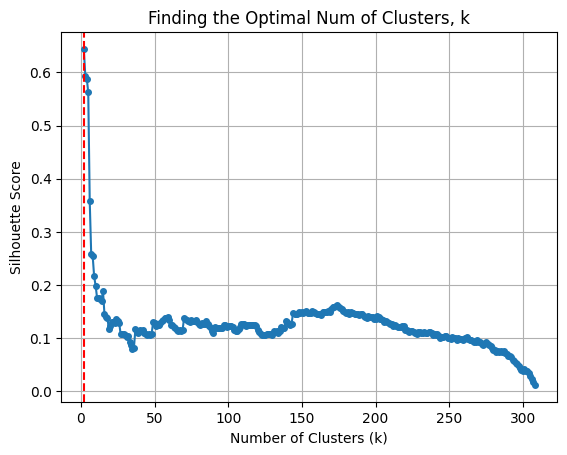

In [67]:
k_values = range(2, 309)

plt.plot(k_values, all_agglo_silhouette_score_arr, marker = "o", markersize = 4)
plt.xlabel("Number of Clusters (k)")
plt.axvline(x=2, color='r', linestyle='--')
plt.ylabel("Silhouette Score")
plt.title("Finding the Optimal Num of Clusters, k")
plt.grid(True)
plt.show()

In [68]:
tuned_agglo = AgglomerativeClustering(n_clusters=2, linkage='average', metric='precomputed')
tuned_clusters = tuned_agglo.fit_predict(gower_dist)
model_result_df = model_df.copy()
model_result_df['ClusterLabel'] = tuned_clusters
model_result_df

ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
305       95B  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
306        99  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
307       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
308        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
309        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
305  POLYGON ((103.77201 1.29407, 103.77201 1.29403...     0.000000   
306  POLYGON ((103.67737 1.326, 103.67725 1.32608, ...     2.651150   
307  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
308  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
309  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
305     7.657503     0.000000    34.045952     0.000000     0.000000   
306    27.101825     0.000000     0.000000     0.000000     0.000000   
307    23.604490     0.000000     0.000000     0.000000     0.000000   
308    46.956897    13.853847     0.000000     0.000000     0.000000   
309     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  ...                                           geometry  \
0            0.0  ...  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1            0.0  ...  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2            0.0  ...  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3            0.0  ...  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4            0.0  ...  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..           ...  ...                                                ...   
305          0.0  ...  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
306          0.0  ...  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
307          0.0  ...  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
308          0.0  ...  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
309          0.0  ...  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                                        planning_areas population_served  \
0    [bukit merah, downtown core, queenstown, cleme...           1182510   
1    [bukit merah, downtown core, rochor, queenstow...            825460   
2                      [geylang, toa payoh, serangoon]            373550   
3                                 [hougang, serangoon]            345770   
4                         [hougang, sengkang, seletar]            493500   
..                                                 ...               ...   
305                     

In [69]:
model_result_df['ClusterLabel'].value_counts()

ClusterLabel
0    285
1     25
Name: count, dtype: int64

In [70]:
model_result_df[model_result_df['ClusterLabel'] == 1]

ServiceNo                            original_bus_route_geom  \
14        10e  MULTILINESTRING ((103.84492 1.27396, 103.84706...   
48        12e  LINESTRING (103.83426 1.27561, 103.8344 1.2756...   
77        14e  LINESTRING (103.93453 1.33013, 103.93422 1.331...   
112      174e  LINESTRING (103.7051 1.33996, 103.70505 1.3400...   
132      188e  LINESTRING (103.74579 1.38587, 103.74577 1.385...   
143      196e  MULTILINESTRING ((103.84492 1.27396, 103.84706...   
168       30e  LINESTRING (103.77367 1.2906, 103.77443 1.2902...   
197       43e  LINESTRING (103.90749 1.30415, 103.9059 1.3030...   
205       506  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
208       513  MULTILINESTRING ((103.84492 1.27396, 103.84706...   
209       518  LINESTRING (103.83293 1.30443, 103.83438 1.303...   
210      518A  LINESTRING (103.95017 1.37302, 103.9506 1.3726...   
238       652  MULTILINESTRING ((103.82856 1.37267, 103.82834...   
239       654  MULTILINESTRING ((103.84542 1.27452, 103.84706...   
240       655  MULTILINESTRING ((103.85567 1.27762, 103.85284...   
241       660  MULTILINESTRING ((103.84542 1.27452, 103.84706...   
242       661  MULTILINESTRING ((103.95799 1.37547, 103.95622...   
243       666  MULTILINESTRING ((103.90916 1.40497, 103.91246...   
244       667  LINESTRING (103.85567 1.27762, 103.85284 1.279...   
245       668  MULTILINESTRING ((103.85567 1.27762, 103.85284...   
246       671  MULTILINESTRING ((103.89714 1.38162, 103.89702...   
247       672  MULTILINESTRING ((103.88691 1.37711, 103.88771...   
278      850E  MULTILINESTRING ((103.84407 1.42322, 103.84387...   
280      851e  LINESTRING (103.84096 1.28148, 103.84444 1.285...   
294       89e  MULTILINESTRING ((103.99453 1.37356, 103.9954 ...   

                               buffered_bus_route_geom  NS_MRT_geom  \
14   POLYGON ((103.84569 1.27763, 103.8458 1.27774,...     4.929213   
48   POLYGON ((103.83226 1.27348, 103.83222 1.27349...     1.595739   
77   POLYGON ((103.83557 1.30507, 103.83837 1.30351...    15.706175   
112  POLYGON ((103.70867 1.33811, 103.70862 1.33801...    10.722638   
132  POLYGON ((103.74139 1.38486, 103.74134 1.38501...    13.779755   
143  POLYGON ((103.84569 1.27763, 103.8458 1.27774,...     5.908391   
168  POLYGON ((103.77246 1.29192, 103.77248 1.29194...     2.545252   
197  POLYGON ((103.87284 1.31671, 103.87283 1.31676...     0.000000   
205  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     5.615361   
208  POLYGON ((103.84569 1.27763, 103.8458 1.27774,...     4.592064   
209  POLYGON ((103.83207 1.30285, 103.83143 1.3032,...    10.285027   
210  POLYGON ((103.83435 1.30572, 103.83521 1.30528...    12.285978   
238  POLYGON ((103.82655 1.37684, 103.82652 1.37717...    14.394101   
239  POLYGON ((103.84568 1.27274, 103.84557 1.27273...     4.648786   
240  POLYGON ((103.74017 1.32036, 103.74003 1.31968...     4.551529   
241  POLYGON ((103.83839 1.30466, 103.83838 1.3047,...    12.760678   
242  POLYGON ((103.84412 1.27324, 103.84394 1.27351...     6.165527   
243  POLYGON ((103.8445 1.27241, 103.84219 1.27178,...     4.381583   
244  POLYGON ((103.76866 1.3192, 103.76875 1.3192, ...     5.797849   
245  POLYGON ((103.83866 1.30676, 103.83866 1.30678...    13.109182   
246  POLYGON ((103.83856 1.30411, 103.83829 1.30556...     5.780645   
247  POLYGON ((103.84469 1.27178, 103.84461 1.27177...     5.701191   
278  POLYGON ((103.8261 1.40566, 103.82609 1.40579,...    12.766022   
280  POLYGON ((103.84643 1.37881, 103.84772 1.3785,...    20.063181   
294  POLYGON ((103.88854 1.36791, 103.88846 1.36798...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
14      8.456201    14.810014     8.503010     0.000000    11.480801   
48      9.042635    18.844398     3.999531     8.663542    11.470551   
77      7.258169    12.619398    13.906494     2.610782    10.502498   
112     6.965603    25.672009     8.879295     8.100965     8.540117   
132     5.312337     0.00000

# HDBSCAN with just trunks bus services (without aggregating all the overlap & into 1 col & without aggregating all the OD_Passenger_Volume into 1 col)

In [76]:
hdbscan_model_df = model_df[model_df['Category'] == 'TRUNK'].copy()
hdbscan_model_df

ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
305       95B  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
306        99  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
307       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
308        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
309        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
305  POLYGON ((103.77201 1.29407, 103.77201 1.29403...     0.000000   
306  POLYGON ((103.67737 1.326, 103.67725 1.32608, ...     2.651150   
307  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
308  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
309  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
305     7.657503     0.000000    34.045952     0.000000     0.000000   
306    27.101825     0.000000     0.000000     0.000000     0.000000   
307    23.604490     0.000000     0.000000     0.000000     0.000000   
308    46.956897    13.853847     0.000000     0.000000     0.000000   
309     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  ...  Category  \
0            0.0  ...     TRUNK   
1            0.0  ...     TRUNK   
2            0.0  ...     TRUNK   
3            0.0  ...     TRUNK   
4            0.0  ...     TRUNK   
..           ...  ...       ...   
305          0.0  ...     TRUNK   
306          0.0  ...     TRUNK   
307          0.0  ...     TRUNK   
308          0.0  ...     TRUNK   
309          0.0  ...     TRUNK   

                                              geometry  \
0    LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1    LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2    LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3    LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4    LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..                                                 ...   
305  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
306  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
307  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
308  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
309  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                                        planning_areas population_served  \
0    [bukit merah, downtown core, queenstown, cleme...           1182510   
1    [bukit merah, downtown core, rochor, queenstow...            825460   
2                      [geylang, toa payoh, serangoon]            373550   
3                                 [hougang, ser

In [77]:
hdbscan_model_df['EW_MRT_geom_combined'] = hdbscan_model_df['EW_MRT_geom'] + hdbscan_model_df['CG_MRT_geom']
hdbscan_model_df['CC_MRT_geom_combined'] = hdbscan_model_df['CC_MRT_geom'] + hdbscan_model_df['CE_MRT_geom']
hdbscan_model_df

ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
305       95B  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
306        99  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
307       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
308        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
309        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
305  POLYGON ((103.77201 1.29407, 103.77201 1.29403...     0.000000   
306  POLYGON ((103.67737 1.326, 103.67725 1.32608, ...     2.651150   
307  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
308  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
309  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
305     7.657503     0.000000    34.045952     0.000000     0.000000   
306    27.101825     0.000000     0.000000     0.000000     0.000000   
307    23.604490     0.000000     0.000000     0.000000     0.000000   
308    46.956897    13.853847     0.000000     0.000000     0.000000   
309     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  ...                                     planning_areas  \
0            0.0  ...  [bukit merah, downtown core, queenstown, cleme...   
1            0.0  ...  [bukit merah, downtown core, rochor, queenstow...   
2            0.0  ...                    [geylang, toa payoh, serangoon]   
3            0.0  ...                               [hougang, serangoon]   
4            0.0  ...                       [hougang, sengkang, seletar]   
..           ...  ...                                                ...   
305          0.0  ...                             [queenstown, clementi]   
306          0.0  ...      [pioneer, clementi, jurong east, jurong west]   
307          0.0  ...                 [jurong east, bukit batok, tengah]   
308          0.0  ...                       [bedok, tampines, pasir ris]   
309          0.0  ...                      [tampines, changi, pasir ris]   

    population_served Average_Distance WEEKDAY_TOTAL_TRIPS  \
0             1182510            31.75               90601   
1              825460            24.00              141614   
2              373550             4.80               24239   
3              345770            15.70               40441   
4              493500            26.90               94075   
..                ...              ...                 ...   
305            204320             4.50               12924   
306            434440            16.90               53213  

In [79]:
# hdbscan_features_df = hdbscan_model_df[['NS_MRT_geom', 'EW_MRT_geom', 'DT_MRT_geom', 'CC_MRT_geom',
#        'NE_MRT_geom', 'TE_MRT_geom', 'CG_MRT_geom', 'CE_MRT_geom', 'population_served', 'Average_Distance',
#        'WEEKDAY_TOTAL_TRIPS', 'WEEKEND_TOTAL_TRIPS']].copy()

# hdbscan_features_df = hdbscan_model_df[['NS_MRT_geom', 'EW_MRT_geom', 'DT_MRT_geom', 'CC_MRT_geom',
#        'NE_MRT_geom', 'TE_MRT_geom', 'CG_MRT_geom', 'CE_MRT_geom', 'population_served', 'Average_Distance',
#        'WEEKDAY_TOTAL_TRIPS', 'WEEKEND_TOTAL_TRIPS']].copy()
hdbscan_features_df = hdbscan_model_df[['NS_MRT_geom', 'EW_MRT_geom_combined', 'DT_MRT_geom', 'CC_MRT_geom_combined',
       'NE_MRT_geom', 'TE_MRT_geom', 'population_served', 'Average_Distance',
       'WEEKDAY_TOTAL_TRIPS', 'WEEKEND_TOTAL_TRIPS']].copy()
hdbscan_features_df

NS_MRT_geom  EW_MRT_geom_combined  DT_MRT_geom  CC_MRT_geom_combined  \
0       2.972384             10.551139    11.262341             21.928317   
1       3.870323             24.357644    13.008207             16.471825   
2       0.000000              6.914730     8.225779              9.445115   
3       0.000000              0.000000     0.000000              8.583609   
4       0.000000              0.000000     0.000000              0.000000   
..           ...                   ...          ...                   ...   
305     0.000000              7.657503     0.000000             34.045952   
306     2.651150             27.101825     0.000000              0.000000   
307     4.607516             23.604490     0.000000              0.000000   
308     0.000000             46.956897    13.853847              0.000000   
309     0.000000              2.875882     9.627685              0.000000   

     NE_MRT_geom  TE_MRT_geom  population_served  Average_Distance  \
0       3.389237     4.566382            1182510             31.75   
1      10.057989     1.929063             825460             24.00   
2      29.203597     0.000000             373550              4.80   
3      40.108129     0.000000             345770             15.70   
4      16.833713     0.000000             493500             26.90   
..           ...          ...                ...               ...   
305     0.000000     0.000000             204320              4.50   
306     0.000000     0.000000             434440             16.90   
307     0.000000     0.000000             250260              9.20   
308     0.000000     0.000000             706550              8.40   
309     0.000000     0.000000             431660             11.00   

     WEEKDAY_TOTAL_TRIPS  WEEKEND_TOTAL_TRIPS  
0                  90601                30900  
1                 141614                49761  
2                  24239                 7949  
3                  40441                15407  
4                  94075                32852  
..                   ...                  ...  
305                12924                 1296  
306                53213                18682  
307                 8193                 2717  
308                70091                24602  
309                25191                 8744  

[285 rows x 10 columns]

In [80]:
from sklearn.preprocessing import StandardScaler
import hdbscan 

scaler = StandardScaler()
scaled_hdbscan_features_df = scaler.fit_transform(hdbscan_features_df)
scaled_hdbscan_features_df

hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean')

# Fit the model
hdbscan_cluster_labels = hdbscan_clusterer.fit_predict(scaled_hdbscan_features_df)
hdbscan_cluster_labels

hdbscan_model_result_df = hdbscan_model_df.copy()
hdbscan_model_result_df['ClusterLabel'] = hdbscan_cluster_labels
hdbscan_model_result_df

ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
305       95B  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
306        99  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
307       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
308        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
309        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
305  POLYGON ((103.77201 1.29407, 103.77201 1.29403...     0.000000   
306  POLYGON ((103.67737 1.326, 103.67725 1.32608, ...     2.651150   
307  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
308  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
309  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
305     7.657503     0.000000    34.045952     0.000000     0.000000   
306    27.101825     0.000000     0.000000     0.000000     0.000000   
307    23.604490     0.000000     0.000000     0.000000     0.000000   
308    46.956897    13.853847     0.000000     0.000000     0.000000   
309     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  ...  population_served Average_Distance WEEKDAY_TOTAL_TRIPS  \
0            0.0  ...            1182510            31.75               90601   
1            0.0  ...             825460            24.00              141614   
2            0.0  ...             373550             4.80               24239   
3            0.0  ...             345770            15.70               40441   
4            0.0  ...             493500            26.90               94075   
..           ...  ...                ...              ...                 ...   
305          0.0  ...             204320             4.50               12924   
306          0.0  ...             434440            16.90               53213   
307          0.0  ...             250260             9.20                8193   
308          0.0  ...             706550             8.40               70091   
309          0.0  ...             431660            11.00               25191   

    WEEKEND_TOTAL_TRIPS  is_trunk  is_express  is_citylink  \
0                 30900         1           0            0   
1                 49761         1           0            0   
2                  7949         1           0            0   
3                 15407         1           0            0   
4                 32852         1           0            0   
..                  ...       ...         ...          ...   
305                1296         1           0            0   


In [81]:
hdbscan_model_result_df['ClusterLabel'].value_counts()

ClusterLabel
-1     204
 7      16
 1       9
 8       6
 5       6
 6       6
 3       6
 11      6
 12      5
 9       5
 4       4
 0       3
 13      3
 2       3
 10      3
Name: count, dtype: int64

In [83]:
# hdbscan_model_result_df.groupby(['ClusterLabel']).agg({
#     'NS_MRT_geom': ['mean'], 
#     'EW_MRT_geom': ['mean'], 
#     'DT_MRT_geom': ['mean'], 
#     'CC_MRT_geom': ['mean'],
#     'NE_MRT_geom': ['mean'], 
#     'TE_MRT_geom': ['mean'], 
#     'CG_MRT_geom': ['mean'], 
#     'CE_MRT_geom': ['mean'], 
#     'population_served': ['mean'],
#     'WEEKDAY_TOTAL_TRIPS': ['mean'], 
#     'WEEKEND_TOTAL_TRIPS': ['mean']
# })

hdbscan_model_result_df.groupby(['ClusterLabel']).agg({
    'NS_MRT_geom': ['mean'], 
    'EW_MRT_geom_combined': ['mean'], 
    'DT_MRT_geom': ['mean'], 
    'CC_MRT_geom_combined': ['mean'],
    'NE_MRT_geom': ['mean'], 
    'TE_MRT_geom': ['mean'], 
    'population_served': ['mean'],
    'Average_Distance': ['mean'],
    'WEEKDAY_TOTAL_TRIPS': ['mean'], 
    'WEEKEND_TOTAL_TRIPS': ['mean']
})

NS_MRT_geom EW_MRT_geom_combined DT_MRT_geom  \
                    mean                 mean        mean   
ClusterLabel                                                
-1              5.833582            10.562501    7.511017   
 0              3.032021             9.079859    0.000000   
 1              0.000000            11.096679    0.056339   
 2             13.023494             7.517801   13.716900   
 3              5.197062             7.044864   10.557342   
 4              6.134212            13.096937   12.313934   
 5              0.000000             7.894686    2.395709   
 6              5.063191             4.836479   12.480459   
 7              0.000000            16.144709   17.210249   
 8             16.635973             0.000000    0.000000   
 9              0.000000             0.000000    0.000000   
 10             0.883717            25.597377    0.000000   
 11             0.000000            17.466272    0.000000   
 12             0.000000             0.780929    0.000000   
 13             0.000000             3.028422    2.246468   

             CC_MRT_geom_combined NE_MRT_geom TE_MRT_geom population_served  \
                             mean        mean        mean              mean   
ClusterLabel                                                                  
-1                       5.312913    6.517991    4.140683      6.671688e+05   
 0                       5.977123    0.000000   24.591784      4.572700e+05   
 1                      38.369557    0.000000    0.901501      1.788122e+05   
 2                       9.336654   10.684544    9.905513      9.945067e+05   
 3                      19.339386    2.963789    1.292498      1.163280e+06   
 4                       8.889304    2.556685    7.908517      7.123575e+05   
 5                       1.080791    6.094305    0.000000      9.618167e+05   
 6                       3.663540    2.000358    1.130243      1.195560e+06   
 7                       0.000000    0.000000    0.028675      4.125019e+05   
 8                       0.000000    1.393236    0.513099      4.087450e+05   
 9                       0.000000   26.396703    0.000000      3.341640e+05   
 10                      0.000000    0.000000    0.000000      3.167067e+05   
 11                      0.000000    0.000000    0.000000      3.022517e+05   
 12                      0.000000    6.651589    0.000000      2.546940e+05   
 13                      0.000000    2.588762    0.000000      5.962200e+05   

             Average_Distance WEEKDAY_TOTAL_TRIPS WEEKEND_TOTAL_TRIPS  
                         mean                mean                mean  
ClusterLabel                                                           
-1                  18.308333        83841.549020        31523.112745  
 0                  22.466667        23931.666667        10053.000000  
 1                   8.966667        19287.222222         3231.777778  
 2                  24.900000       149737.000000        49048.666667  
 3                  22.533333        65723.833333        20652.333333  
 4                  22.362500       100964.750000        34340.750000  
 5                  41.233333        91088.166667        32824.333333  
 6                  25.550000       127858.833333        34539.000000  
 7                   7.568750        30375.937500         9765.062500  
 8                   6.500000         8128.333333         2709.833333  
 9                   4.820000        13157.200000         4994.600000  
 10                 14.266667        52889.000000        17359.000000  
 11                  7.650000        21021.833333         6671.000000  
 12                  6.260000        15918.400000         5620.600000  
 13                 11.200000        20920.333333         6479.000000

# Clustering using HDBSCAN: Aggregate all the overlap % into 1 col, Aggregate all the OD_Passenger_Vol into 1 col

## with min_cluster_size = 3

In [84]:
new_hdbscan_model_df = hdbscan_model_df.copy()
new_hdbscan_model_df['total_overlap_pct'] = new_hdbscan_model_df['NS_MRT_geom'] + new_hdbscan_model_df['EW_MRT_geom'] + new_hdbscan_model_df['DT_MRT_geom'] + new_hdbscan_model_df['CC_MRT_geom'] + new_hdbscan_model_df['NE_MRT_geom'] + new_hdbscan_model_df['TE_MRT_geom'] + new_hdbscan_model_df['CG_MRT_geom'] + new_hdbscan_model_df['CE_MRT_geom'] 
new_hdbscan_model_df['total_od_volume'] = new_hdbscan_model_df['WEEKDAY_TOTAL_TRIPS'] + new_hdbscan_model_df['WEEKEND_TOTAL_TRIPS'] 

new_hdbscan_features_df = new_hdbscan_model_df[['total_overlap_pct', 'population_served', 'Average_Distance', 'total_od_volume']].copy()
new_hdbscan_features_df

total_overlap_pct  population_served  Average_Distance  total_od_volume
0            54.669799            1182510             31.75           121501
1            69.695052             825460             24.00           191375
2            53.789220             373550              4.80            32188
3            48.691738             345770             15.70            55848
4            16.833713             493500             26.90           126927
..                 ...                ...               ...              ...
305          41.703455             204320              4.50            14220
306          29.752974             434440             16.90            71895
307          28.212006             250260              9.20            10910
308          60.810744             706550              8.40            94693
309          12.503566             431660             11.00            33935

[285 rows x 4 columns]

In [85]:
new_hdbscan_scaler = StandardScaler()
scaled_new_hdbscan_features_df = new_hdbscan_scaler.fit_transform(new_hdbscan_features_df)
scaled_new_hdbscan_features_df

array([[ 0.81795265,  1.50805426,  1.39606987,  0.15160484],
       [ 1.53467013,  0.52198093,  0.64906308,  0.65060586],
       [ 0.77594823, -0.72606948, -1.201586  , -0.48621864],
       ...,
       [-0.4441069 , -1.06656235, -0.77747892, -0.63817422],
       [ 1.110881  ,  0.1935844 , -0.8545893 , -0.0398429 ],
       [-1.19341299, -0.56558573, -0.60398057, -0.47374255]])

In [86]:
new_hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean')

# Fit the model
new_hdbscan_cluster_labels = new_hdbscan_clusterer.fit_predict(scaled_new_hdbscan_features_df)
new_hdbscan_cluster_labels

new_hdbscan_model_result_df = new_hdbscan_model_df.copy()
new_hdbscan_model_result_df['ClusterLabel'] = new_hdbscan_cluster_labels
new_hdbscan_model_result_df

ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
305       95B  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
306        99  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
307       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
308        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
309        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
305  POLYGON ((103.77201 1.29407, 103.77201 1.29403...     0.000000   
306  POLYGON ((103.67737 1.326, 103.67725 1.32608, ...     2.651150   
307  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
308  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
309  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
305     7.657503     0.000000    34.045952     0.000000     0.000000   
306    27.101825     0.000000     0.000000     0.000000     0.000000   
307    23.604490     0.000000     0.000000     0.000000     0.000000   
308    46.956897    13.853847     0.000000     0.000000     0.000000   
309     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  ...  WEEKDAY_TOTAL_TRIPS WEEKEND_TOTAL_TRIPS is_trunk  \
0            0.0  ...                90601               30900        1   
1            0.0  ...               141614               49761        1   
2            0.0  ...                24239                7949        1   
3            0.0  ...                40441               15407        1   
4            0.0  ...                94075               32852        1   
..           ...  ...                  ...                 ...      ...   
305          0.0  ...                12924                1296        1   
306          0.0  ...                53213               18682        1   
307          0.0  ...                 8193                2717        1   
308          0.0  ...                70091               24602        1   
309          0.0  ...                25191                8744        1   

    is_express  is_citylink  EW_MRT_geom_combined  CC_MRT_geom_combined  \
0            0            0             10.551139             21.928317   
1            0            0             24.357644             16.471825   
2            0            0              6.914730              9.445115   
3            0            0              0.000000              8.583609   
4            0            0              0.000000              0.000000   
..         ...          ...                   ...                   ...   
305          0            0              7.

In [87]:
new_hdbscan_model_result_df['ClusterLabel'].value_counts()

ClusterLabel
-1    137
 4    119
 0     18
 1      4
 2      4
 3      3
Name: count, dtype: int64

In [89]:
new_hdbscan_model_result_df.groupby(['ClusterLabel']).agg({
    'total_overlap_pct': ['mean'], 
    'population_served': ['mean'], 
    'Average_Distance':['mean'],
    'total_od_volume': ['mean'], 
})

total_overlap_pct population_served Average_Distance  \
                          mean              mean             mean   
ClusterLabel                                                        
-1                   42.282749      7.718806e+05        23.068613   
 0                   63.943227      8.900628e+05        24.805556   
 1                   44.946571      8.134825e+05        17.975000   
 2                   36.079824      8.341775e+05        22.425000   
 3                   28.521957      1.102620e+06        23.616667   
 4                   28.071063      4.178341e+05         9.088235   

             total_od_volume  
                        mean  
ClusterLabel                  
-1             147469.664234  
 0             173013.166667  
 1             146940.750000  
 2              64041.750000  
 3             138314.666667  
 4              33622.663866

## with min_cluster_size = 5

In [90]:
new_hdbscan_clusterer_size5 = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')

# Fit the model
new_hdbscan_cluster_labels_size5 = new_hdbscan_clusterer_size5.fit_predict(scaled_new_hdbscan_features_df)
new_hdbscan_cluster_labels_size5

new_hdbscan_model_result_df_size5 = new_hdbscan_model_df.copy()
new_hdbscan_model_result_df_size5['ClusterLabel'] = new_hdbscan_cluster_labels_size5
new_hdbscan_model_result_df_size5

ServiceNo                            original_bus_route_geom  \
0          10  LINESTRING (103.76868 1.29202, 103.76821 1.292...   
1         100  LINESTRING (103.78715 1.31167, 103.78688 1.311...   
2        100A  LINESTRING (103.87136 1.35037, 103.87167 1.348...   
3         101  LINESTRING (103.87136 1.35037, 103.87163 1.348...   
4         102  LINESTRING (103.86909 1.39288, 103.8691 1.3934...   
..        ...                                                ...   
305       95B  LINESTRING (103.77024 1.29436, 103.77017 1.294...   
306        99  LINESTRING (103.67842 1.32745, 103.67899 1.327...   
307       993  LINESTRING (103.73549 1.34197, 103.73577 1.342...   
308        9A  LINESTRING (103.92899 1.32472, 103.92868 1.324...   
309        9B  LINESTRING (103.95349 1.34223, 103.95591 1.344...   

                               buffered_bus_route_geom  NS_MRT_geom  \
0    POLYGON ((103.7681 1.29032, 103.76795 1.29038,...     2.972384   
1    POLYGON ((103.78383 1.31313, 103.78383 1.31314...     3.870323   
2    POLYGON ((103.86945 1.34562, 103.86973 1.34634...     0.000000   
3    POLYGON ((103.87279 1.3516, 103.87397 1.35273,...     0.000000   
4    POLYGON ((103.86712 1.40364, 103.86704 1.40361...     0.000000   
..                                                 ...          ...   
305  POLYGON ((103.77201 1.29407, 103.77201 1.29403...     0.000000   
306  POLYGON ((103.67737 1.326, 103.67725 1.32608, ...     2.651150   
307  POLYGON ((103.73399 1.34296, 103.73413 1.34321...     4.607516   
308  POLYGON ((103.93026 1.32598, 103.9306 1.32602,...     0.000000   
309  POLYGON ((103.95406 1.35046, 103.95348 1.35086...     0.000000   

     EW_MRT_geom  DT_MRT_geom  CC_MRT_geom  NE_MRT_geom  TE_MRT_geom  \
0      10.551139    11.262341    21.928317     3.389237     4.566382   
1      24.357644    13.008207    16.471825    10.057989     1.929063   
2       6.914730     8.225779     9.445115    29.203597     0.000000   
3       0.000000     0.000000     8.583609    40.108129     0.000000   
4       0.000000     0.000000     0.000000    16.833713     0.000000   
..           ...          ...          ...          ...          ...   
305     7.657503     0.000000    34.045952     0.000000     0.000000   
306    27.101825     0.000000     0.000000     0.000000     0.000000   
307    23.604490     0.000000     0.000000     0.000000     0.000000   
308    46.956897    13.853847     0.000000     0.000000     0.000000   
309     2.875882     9.627685     0.000000     0.000000     0.000000   

     CG_MRT_geom  ...  WEEKDAY_TOTAL_TRIPS WEEKEND_TOTAL_TRIPS is_trunk  \
0            0.0  ...                90601               30900        1   
1            0.0  ...               141614               49761        1   
2            0.0  ...                24239                7949        1   
3            0.0  ...                40441               15407        1   
4            0.0  ...                94075               32852        1   
..           ...  ...                  ...                 ...      ...   
305          0.0  ...                12924                1296        1   
306          0.0  ...                53213               18682        1   
307          0.0  ...                 8193                2717        1   
308          0.0  ...                70091               24602        1   
309          0.0  ...                25191                8744        1   

    is_express  is_citylink  EW_MRT_geom_combined  CC_MRT_geom_combined  \
0            0            0             10.551139             21.928317   
1            0            0             24.357644             16.471825   
2            0            0              6.914730              9.445115   
3            0            0              0.000000              8.583609   
4            0            0              0.000000              0.000000   
..         ...          ...                   ...                   ...   
305          0            0              7.

In [91]:
new_hdbscan_model_result_df_size5['ClusterLabel'].value_counts()

ClusterLabel
 1    160
-1    113
 0     12
Name: count, dtype: int64

In [92]:
new_hdbscan_model_result_df_size5.groupby(['ClusterLabel']).agg({
    'total_overlap_pct': ['mean'], 
    'population_served': ['mean'], 
    'Average_Distance':['mean'],
    'total_od_volume': ['mean'], 
})

total_overlap_pct population_served Average_Distance  \
                          mean              mean             mean   
ClusterLabel                                                        
-1                   45.685130     829319.292035        24.725221   
 0                   65.256611     908167.500000        24.079167   
 1                   29.677148     479865.250000        11.487188   

             total_od_volume  
                        mean  
ClusterLabel                  
-1             162294.787611  
 0             183772.916667  
 1              50206.037500